# Using Deep Learning to Study SUSY with PyTorch

## Learning Goals

The goal of this notebook is to introduce the powerful PyTorch framework for building neural networks and use it to analyze the SUSY dataset. After this notebook, the reader should understand the mechanics of PyTorch and how to construct DNNs using this package. In addition, the reader is encouraged to explore the GPU backend available in Pytorch on this dataset.


## Overview

### Description of Data 

We use Deep Neural Networks to classify the supersymmetry dataset, first introduced by [Baldi et al. in Nature Communication (2015)](https://www.nature.com/articles/ncomms5308). The SUSY data set consists of 5,000,000 Monte-Carlo samples of supersymmetric and non-supersymmetric collisions with  18 features. The signal process is the production of electrically-charged supersymmetric particles which decay to  W bosons and an electrically-neutral supersymmetric particle that is invisible to the detector.

**The first  8 features are "raw" kinematic features that can be directly measured from collisions. The final  10 features are "hand constructed" features** that have been chosen using physical knowledge and are known to be important in distinguishing supersymmetric and non-supersymmetric collision events. More specifically, they are given by the column names below.


**low_features=**\['lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 
 'missing energy magnitude', 'missing energy phi'\]

**high_features=**\['MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2','S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)'\]




From https://archive.ics.uci.edu/ml/datasets/SUSY:  the following image displays the signal (a) vs the background (b): the signal involves an hypotethical supersymmetric particle $\chi^{\pm}$ and $\chi^{0}$ (undetected) along with charged leptons $l^{\pm}$ and neutrinos $\nu$. 
The background process involves $W$ bosons decaying in leptons $l^{\pm}$ and neutrinos $\nu$. In both cases, the resulting observed particles are two charged leptons, since neutrinos and $\chi^{0}$ escape undetected.

![signal (a) VS background (b)](SUSY.png)

The classification task requires distinguishing between these two processes and the missing transverse momentum. Simulated events are generated with MADGRAPH event generator assuming 8 TeV collisions of protons at LHC, with showering and hadronization performed by PYTHIA and detector response simulated by DELPHES. 
Notice the masses are set to $m_{\chi^{\pm}}=$ 200 GeV and $m_{\chi^{0}}$ = 100 GeV. 
We focus on fully leptonic decay mode of $W$ bosons, both into $l\nu$ (final state $l\nu l\nu$).

We consider events which satisfy the requirements:
- exactly two electrons or muons each with $p_{\perp}>$ 20 GeV and $|\eta|<$ 2.5
- at least 20 GeV of missing transverse mass 

The basic detector response is used to measure the momentum of each visible particle, basically leptoons, though there may be particle jets induced by radiative processes. 
A critical quantity if the missing transverse momentum $E_{T}$. 

High-level features to select signal vs background (cannot have invariant mass here due to undetected particles):

- **axial $E_{T}$**: missing transverse energy along the vector defined by the charged leptons 

- **transverse mass M_{T2}**: estimating the mass of particles produced in pairs and decaying semi-invisibly [17,18]

- **$E_{T}^{Rel}$**: $E_{T}$ if $\Delta \phi \leq \pi /2$,  $E_{T} \sin{(\Delta\phi)}$ if $\Delta \phi < \pi /2$, where $\Delta\phi$ is the minimum angle between $E_{T}$ and a jet or lepton 

- **razor quantities: $\beta, R$ and $M_{R}$** [19]

- **super-razor quantities $\beta_{R+1}, \cos{(\theta_{R+1}), \Delta\Phi_{R}^{\beta}}, M_{\Delta}^{R}, M_{R}^{T}$ and $\sqrt{\hat{s}_{R}}$** [20]



## Structure and Procedure

Constructing a Deep Neural Network to solve ML problems is a multiple-stage process. Quite generally, one can identify the key steps as follows:
</br>

- step 1: Load and process the data

- step 2: Define the model and its architecture

- step 3: Choose the optimizer and the cost function

- step 4: Train the model

- step 5: Evaluate the model performance on the unseen test data

- step 6: Modify the hyperparameters to optimize performance for the specific data set

</br>
Below, we sometimes combine some of these steps together for convenience.
Notice that we take a rather different approach, compared to the simpler MNIST Keras notebook. We first define a set of classes and functions and run the actual computation only in the very end.

## Load and Process the SUSY Data 

The supersymmetry dataset can be downloaded from the UCI Machine Learning repository on https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz. The dataset is quite large. Download the dataset and unzip it in a directory.


Loading data in Pytroch is done by creating a user-defined class, which we name **SUSY_Dataset**, and is a child of the **torch.utils.data.Dataset** class. This ensures that all necessary attributes required for the processing of the data during the training and test stages are easily inherited. The \_\_init\_\_ method of our custom data class should contain the usual code for loading the data, which is problem-specific, and has been discussed for the SUSY data set in previous notebooks. 

More importantly, the user-defined **data class must override** the **\_\_len\_\_** and **\_\_getitem\_\_** methods of the **parent DataSet class**. The former returns the size of the data set, while the latter allows the user to access a particular data point from the set by specifying its index.

The **\_\_init\_\_()** method bulk-converts all NumPy array data to PyTorch tensors. An alternative is to leave the data in memory as NumPy arrays and then convert to batches of data to tensors in the **\_\_getitem\_\_** method.
The `__getitem___` method is crucial to iterate over the dataset. This is defined in the class SUSY_Dataset, which is eventually inherited by the class `torch.utils.data.DataLoader` that defines `train_loader` and `test_loader`. 

Eventually this allows to loop over the training (testing) data:
`for batch_idx, (data, label) in enumerate(train_loader):`



In [ ]:
from __future__ import print_function, division
import os,sys
import numpy as np
import torch # pytorch package, allows using GPUs

from platform import python_version

print(python_version())

# fix seed
seed=17
np.random.seed(seed)
torch.manual_seed(seed)

torch.cuda.current_device()

torch.cuda.device(0)

torch.cuda.device_count()

print(torch.cuda.get_device_name(0), torch.cuda.is_available(), ", cuda: ", torch.version.cuda)

3.7.12
Tesla K80 True , cuda:  11.1


In [ ]:
from torchvision import datasets # load data

class SUSY_Dataset(torch.utils.data.Dataset):  #https://pytorch.org/docs/stable/data.html
    """SUSY pytorch dataset."""

    def __init__(self, data_file, root_dir, dataset_size, train=True, transform=None, high_level_feats=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            train (bool, optional): If set to `True` load training data.
            transform (callable, optional): Optional transform to be applied on a sample.
            high_level_festures (bool, optional): If set to `True`, working with high-level features only. 
                                        If set to `False`, working with low-level features only.
                                        Default is `None`: working with all features
        """

        import pandas as pd

        features=['SUSY','lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 
                'missing energy magnitude', 'missing energy phi', 'MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2', 
                'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']

        low_features=['lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 
                'missing energy magnitude', 'missing energy phi']

        high_features=['MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2','S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']


        #Number of datapoints to work with
        df = pd.read_csv(root_dir+data_file, header=None,nrows=dataset_size,engine='python')
        df.columns=features
        Y = df['SUSY']
        X = df[[col for col in df.columns if col!="SUSY"]]

        # set training and test data size
        train_size=int(0.8*dataset_size)
        self.train=train

        if self.train:
            X=X[:train_size]
            Y=Y[:train_size]
            print("Training on {} examples".format(train_size))
        else:
            X=X[train_size:]
            Y=Y[train_size:]
            print("Testing on {} examples".format(dataset_size-train_size))


        self.root_dir = root_dir
        self.transform = transform

        # make datasets using only the 8 low-level features and 10 high-level features
        if high_level_feats is None:
            self.data=(X.values.astype(np.float32),Y.values.astype(int))
            print("Using both high and low level features")
        elif high_level_feats is True:
            self.data=(X[high_features].values.astype(np.float32),Y.values.astype(int))
            print("Using both high-level features only.")
        elif high_level_feats is False:
            self.data=(X[low_features].values.astype(np.float32),Y.values.astype(int))
            print("Using both low-level features only.")


    # override __len__ and __getitem__ of the Dataset() class

    def __len__(self):
        return len(self.data[1])

    def __getitem__(self, idx):

        sample=(self.data[0][idx,...],self.data[1][idx])

        if self.transform:
            sample=self.transform(sample)

        return sample

Last, we define a helper function load_data() that accepts as a required argument the set of parameters args, and returns two generators: test_loader and train_loader which readily return mini-batches.

In [ ]:

def load_data(args):

    from google.colab import drive 
    drive.mount('/content/gdrive')

    #import pandas as pd
    #df_test=pd.read_csv('gdrive/My Drive/ML4HEP_Course/data/datashrunk_SUSY_2.csv')
    
    data_file='SUSY.csv' #'datashrunk_SUSY_2.csv' #'SUSY.csv'
    #root_dir=os.path.expanduser('~')+'/Desktop/ML4HEP/data/'
    root_dir='gdrive/My Drive/ML4HEP_Course/data/'

    kwargs = {} # CUDA arguments, if enabled
    # load and normalise train and test data
    train_loader = torch.utils.data.DataLoader(
        SUSY_Dataset(data_file,root_dir,args.dataset_size,train=True,high_level_feats=args.high_level_feats),
        batch_size=args.batch_size, shuffle=True, **kwargs)

    test_loader = torch.utils.data.DataLoader(
        SUSY_Dataset(data_file,root_dir,args.dataset_size,train=False,high_level_feats=args.high_level_feats),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    return train_loader, test_loader


## Step 2: Define the NN Architecture 

To construct neural networks with Pytorch, we make another class called model as a child of `Pytorch's nn.Module`  class. The model class initializes the types of layers needed for the deep neural net in its `__init__` method, while the DNN is assembled in a function method called `forward`, which accepts an `autograd.Variable` object and returns the output layer. Using this convention Pytorch will automatically recognize the structure of the DNN, and the `autograd` module will pull the gradients forward and backward using backprop.

Our code below is constructed in such a way that one can choose whether to use the high-level and low-level features separately and altogether. This choice determines the size of the fully-connected input layer `fc1`. Therefore the `__init__` method accepts the optional argument `high_level_feats`.

In [ ]:
import torch.nn as nn # construct NN

class model(nn.Module):
    def __init__(self,high_level_feats=None):
        # inherit attributes and methods of nn.Module
        super(model, self).__init__()
        #super().__init__()  ##py3 actually only super()

        # an affine operation: y = Wx + b
        if high_level_feats is None:
            self.fc1 = nn.Linear(18, 200) # all features
        elif high_level_feats:
            self.fc1 = nn.Linear(10, 200) # low-level only
        else:
            self.fc1 = nn.Linear(8, 200) # high-level only

        # Batch Normalization is a regularization scheme that has been quickly adopted by the neural network 
        # community since its introduction in 2015 (Ioffe 2015)

        self.batchnorm1=nn.BatchNorm1d(200, eps=1e-05, momentum=0.1)
        self.batchnorm2=nn.BatchNorm1d(100, eps=1e-05, momentum=0.1)

        self.fc2 = nn.Linear(200, 100) # see forward function for dimensions
        self.fc3 = nn.Linear(100, 2)
        
        # NOTES
        # All we're doing is just defining values for some layers, we're calling them fc1, fc2...etc, 
        # but you could call them whatever you wanted. The fc just stands for fully connected.
        
        # Each of our nn.Linear layers expects the first parameter to be the input size, 
        # and the 2nd parameter is the output size.
        # So our first layer takes 18 values if we are using all the 18 features.

    def forward(self, x):
        '''Defines the feed-forward function for the NN.

        A backward function is automatically defined using `torch.autograd`

        Parameters
        ----------
        x : autograd.Tensor
            input data

        Returns
        -------
        autograd.Tensor
            output layer of NN

        '''

        # apply rectified linear unit
        x = F.relu(self.fc1(x))
        # apply dropout
        #x=self.batchnorm1(x)
        x = F.dropout(x, training=self.training)


        # apply rectified linear unit
        x = F.relu(self.fc2(x))
        # apply dropout
        #x=self.batchnorm2(x)
        x = F.dropout(x, training=self.training)


        # apply affine operation fc2
        x = self.fc3(x)
        # soft-max layer
        x = F.log_softmax(x,dim=1)

        return x

### Steps 3+4+5: Choose the Optimizer and the Cost Function. Train and Evaluate the Model

Next, we define the function `evaluate_model`. 

- The first argument, `args`, contains all hyperparameters needed for the DNN (see below). 
- The second and third arguments are the `train_loader` and the `test_loader` objects, returned by the function `load_data()` we defined in Step 1 above. The evaluate_model function returns the final `test_loss` and `test_accuracy` of the model.

First, we initialize a model and call the object `DNN`. In order to define the loss function and the optimizer, we use modules `torch.nn.functional` (imported here as F) and `torch.optim`. As a loss function we choose the **negative log-likelihood**, and stored it under the variable criterion. 
As usual, we can choose any from a variety of different SGD-based optimizers, but we focus on the traditional SGD.

Next, we define two functions: `train()` and `test()`. They are called at the end of `evaluate_model` where we loop over the training epochs to train and test our model.

The `train` function accepts an integer called epoch, which is only used to print the training data. We first set the DNN in a train mode using the `train()` method inherited from `nn.Module`. Then we loop over the mini-batches in `train_loader`. We cast the data as pytorch `Variable`, re-set the `optimizer`, perform the forward step by calling the DNN model on the data and computing the loss. The backprop algorithm is then easily done using the `backward()` method of the loss function criterion. We use `optimizer.step` to update the weights of the DNN. Last print the performance for every minibatch. `train` returns the loss on the data.

The `test` function is similar to train but its purpose is to test the performance of a trained model. Once we set the DNN model in `eval()` mode, the following steps are similar to those in train. We then compute the `test_loss` and the number of correct predictions, print the results and return them.

Notice the `DataLoader` class is designed so that it can be iterated using the enumerate() function, which returns a tuple with the current batch zero-based index value, and the actual batch of data. 

In [ ]:
import torch.nn.functional as F # implements forward and backward definitions of an autograd operation
import torch.optim as optim # different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc

from tqdm import tqdm 
from tqdm import trange 
from time import sleep



def evaluate_model(args,train_loader,test_loader):
    
    
    
    device = torch.device("cuda" if args.no_cuda else "cpu")


    # create model
    DNN = model(high_level_feats=args.high_level_feats).to(device) 

    # negative log-likelihood (nll) loss for training: takes class labels NOT one-hot vectors!
    criterion = F.nll_loss
    # define SGD optimizer
    optimizer = optim.SGD(DNN.parameters(), lr=args.lr, momentum=args.momentum)
    #optimizer = optim.Adam(DNN.parameters(), lr=0.001, betas=(0.9, 0.999))

    
    
    
    ################################################

    def train(epoch, device):
        '''Trains a NN using minibatches.

        Parameters
        ----------
        epoch : int
            Training epoch number.

        '''

        # set model to training mode (affects Dropout and BatchNorm)
        DNN.train()
        
       
        
        # to handle stream 
        with tqdm(train_loader, unit="batch") as tepoch:
        
            # loop over training data
            #for batch_idx, (data, label) in enumerate(train_loader):
            for batch_idx, (data, label) in enumerate(tepoch):
                
                tepoch.set_description(f"Epoch {epoch}")
                
                data, label = data.to(device), label.to(device)
                
                # zero gradient buffers
                optimizer.zero_grad()
                # compute output of final layer: forward step
                output = DNN(data)
                # compute loss
                loss = criterion(output, label)
                # run backprop: backward step
                loss.backward()
                # update weigths of NN
                optimizer.step()

                # print loss at current epoch
                if batch_idx % args.log_interval == 0:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.item() ))


                # difference between len(train_loader.dataset) and len(train_loader)

                tepoch.set_postfix(loss=loss.item())
                sleep(0.1)
                
            return loss.item()    
    
    
        
        
    ################################################

    def test(device):
        '''Tests NN performance.

        '''

        # evaluate model
        DNN.eval()

        test_loss = 0 # loss function on test data
        correct = 0 # number of correct predictions
        # loop over test data
        for data, label in test_loader:
            # compute model prediction softmax probability
            
            data, label = data.to(device), label.to(device)
            
            output = DNN(data)
            # compute test loss
            test_loss += criterion(output, label, size_average=False).item() # sum up batch loss
            # find most likely prediction
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            # update number of correct predictions
            correct += pred.eq(label.data.view_as(pred)).cpu().sum().item()

        # print test loss
        test_loss /= len(test_loader.dataset)
        
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
        

        return test_loss, correct / len(test_loader.dataset)
    
    ################################################


    train_loss=np.zeros((args.epochs,))
    test_loss=np.zeros_like(train_loss)
    test_accuracy=np.zeros_like(train_loss)

    epochs=range(1, args.epochs + 1)
    for epoch in epochs:

        train_loss[epoch-1] = train(epoch, device)
        test_loss[epoch-1], test_accuracy[epoch-1] = test(device)



    return test_loss[-1], test_accuracy[-1]    

### Step 6: Modify the Hyperparameters to Optimize Performance of the Model¶

To study the performance of the model for a variety of different `data_set_sizes` and `learning_rates`, we do a grid search.
Let us define a function grid_search, which accepts the args variable containing all hyper-parameters needed for the problem. After choosing logarithmically-spaced `data_set_sizes` and `learning_rates`, we first loop over all `data_set_sizes`, update the args variable, and call the `load_data` function. We then loop once again over all `learning_rates`, update args and call `evaluate_model`.

In [ ]:
def grid_search(args):


    # perform grid search over learnign rate and number of hidden neurons
    dataset_sizes=[10000, 100000] #np.logspace(2,5,4).astype('int')
    learning_rates=np.logspace(-5,-1,3)

    # pre-alocate data
    test_loss=np.zeros((len(dataset_sizes),len(learning_rates)),dtype=np.float64)
    test_accuracy=np.zeros_like(test_loss)

    # do grid search
    for i, dataset_size in enumerate(dataset_sizes):
        # upate data set size parameters
        args.dataset_size=dataset_size
        args.batch_size=int(0.01*dataset_size)

        # load data
        train_loader, test_loader = load_data(args)

        for j, lr in enumerate(learning_rates):
            # update learning rate
            args.lr=lr

            print("\n training DNN with %5d data points and SGD lr=%0.6f. \n" %(dataset_size,lr) )

            test_loss[i,j],test_accuracy[i,j] = evaluate_model(args,train_loader,test_loader)


    plot_data(learning_rates,dataset_sizes,test_accuracy)
    
    

Last, we use the function `plot_data`, defined below, to plot the results.

In [ ]:
import matplotlib.pyplot as plt

def plot_data(x,y,data):

    # plot results
    fontsize=16


    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest', vmin=0, vmax=1)
    
    cbar=fig.colorbar(cax)
    cbar.ax.set_ylabel('accuracy (%)',rotation=90,fontsize=fontsize)
    cbar.set_ticks([0,.2,.4,0.6,0.8,1.0])
    cbar.set_ticklabels(['0%','20%','40%','60%','80%','100%'])

    # put text on matrix elements
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = "${0:.1f}\\%$".format( 100*data[j,i])  
            ax.text(x_val, y_val, c, va='center', ha='center')

    # convert axis vaues to to string labels
    x=[str(i) for i in x]
    y=[str(i) for i in y]


    ax.set_xticklabels(['']+x)
    ax.set_yticklabels(['']+y)

    ax.set_xlabel('$\\mathrm{learning\\ rate}$',fontsize=fontsize)
    ax.set_ylabel('$\\mathrm{hidden\\ neurons}$',fontsize=fontsize)

    plt.tight_layout()

    plt.show()

### Run Code

As we mentioned in the beginning of the notebook, all functions and classes discussed above only specify the procedure but do not actually perform any computations. This allows us to re-use them for different problems.

Actually running the training and testing for every point in the grid search is done below. The `argparse` class allows us to conveniently keep track of all hyperparameters, stored in the variable `args` which enters most of the functions we defined above.

To run the simulation, we call the function `grid_search`.

# Exercises

### GPU and CUDA

One of the advantages of Pytorch is that it allows to automatically use the CUDA library for fast performance on GPU's. For the sake of clarity, we have omitted this in the above notebook. Go online to check how to put the CUDA commands back into the code above. Hint: study the [Pytorch MNIST tutorial](https://github.com/pytorch/examples/blob/master/mnist/main.py) to see how this works in practice.

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Training on 8000 examples
Using both high and low level features
Testing on 2000 examples
Using both high and low level features

 training DNN with 10000 data points and SGD lr=0.000010. 



Epoch 1:   1%|▏         | 1/80 [00:00<00:10,  7.25batch/s, loss=0.699]

Train Epoch: 1 [0/8000 (0%)]	Loss: 0.695737


Epoch 1:  14%|█▍        | 11/80 [00:01<00:07,  8.91batch/s, loss=0.703]

Train Epoch: 1 [1000/8000 (12%)]	Loss: 0.706014


Epoch 1:  26%|██▋       | 21/80 [00:02<00:06,  8.87batch/s, loss=0.709]

Train Epoch: 1 [2000/8000 (25%)]	Loss: 0.693002


Epoch 1:  39%|███▉      | 31/80 [00:03<00:05,  8.91batch/s, loss=0.694]

Train Epoch: 1 [3000/8000 (38%)]	Loss: 0.709861


Epoch 1:  51%|█████▏    | 41/80 [00:04<00:04,  8.93batch/s, loss=0.727]

Train Epoch: 1 [4000/8000 (50%)]	Loss: 0.687155


Epoch 1:  64%|██████▍   | 51/80 [00:05<00:03,  9.00batch/s, loss=0.66] 

Train Epoch: 1 [5000/8000 (62%)]	Loss: 0.702012


Epoch 1:  76%|███████▋  | 61/80 [00:06<00:02,  8.75batch/s, loss=0.709]

Train Epoch: 1 [6000/8000 (75%)]	Loss: 0.697446


Epoch 1:  89%|████████▉ | 71/80 [00:07<00:01,  8.91batch/s, loss=0.718]

Train Epoch: 1 [7000/8000 (88%)]	Loss: 0.712713


Epoch 1: 100%|██████████| 80/80 [00:08<00:00,  8.89batch/s, loss=0.684]
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.6926, Accuracy: 1056/2000 (52.800%)



Epoch 2:   1%|▏         | 1/80 [00:00<00:09,  8.65batch/s, loss=0.705]

Train Epoch: 2 [0/8000 (0%)]	Loss: 0.698672


Epoch 2:  14%|█▍        | 11/80 [00:01<00:07,  8.86batch/s, loss=0.7]  

Train Epoch: 2 [1000/8000 (12%)]	Loss: 0.716177


Epoch 2:  26%|██▋       | 21/80 [00:02<00:06,  8.97batch/s, loss=0.703]

Train Epoch: 2 [2000/8000 (25%)]	Loss: 0.715654


Epoch 2:  39%|███▉      | 31/80 [00:03<00:05,  8.92batch/s, loss=0.706]

Train Epoch: 2 [3000/8000 (38%)]	Loss: 0.711846


Epoch 2:  51%|█████▏    | 41/80 [00:04<00:04,  8.84batch/s, loss=0.697]

Train Epoch: 2 [4000/8000 (50%)]	Loss: 0.690598


Epoch 2:  64%|██████▍   | 51/80 [00:05<00:03,  8.98batch/s, loss=0.702]

Train Epoch: 2 [5000/8000 (62%)]	Loss: 0.727525


Epoch 2:  76%|███████▋  | 61/80 [00:06<00:02,  8.85batch/s, loss=0.709]

Train Epoch: 2 [6000/8000 (75%)]	Loss: 0.689077


Epoch 2:  89%|████████▉ | 71/80 [00:07<00:01,  8.99batch/s, loss=0.682]

Train Epoch: 2 [7000/8000 (88%)]	Loss: 0.681673


Epoch 2: 100%|██████████| 80/80 [00:08<00:00,  8.94batch/s, loss=0.694]



Test set: Average loss: 0.6922, Accuracy: 1057/2000 (52.850%)



Epoch 3:   1%|▏         | 1/80 [00:00<00:08,  9.16batch/s, loss=0.73] 

Train Epoch: 3 [0/8000 (0%)]	Loss: 0.697338


Epoch 3:  14%|█▍        | 11/80 [00:01<00:07,  8.93batch/s, loss=0.73]

Train Epoch: 3 [1000/8000 (12%)]	Loss: 0.709971


Epoch 3:  26%|██▋       | 21/80 [00:02<00:06,  9.02batch/s, loss=0.697]

Train Epoch: 3 [2000/8000 (25%)]	Loss: 0.714695


Epoch 3:  39%|███▉      | 31/80 [00:03<00:05,  8.82batch/s, loss=0.729]

Train Epoch: 3 [3000/8000 (38%)]	Loss: 0.745484


Epoch 3:  51%|█████▏    | 41/80 [00:04<00:04,  8.94batch/s, loss=0.707]

Train Epoch: 3 [4000/8000 (50%)]	Loss: 0.702831


Epoch 3:  64%|██████▍   | 51/80 [00:05<00:03,  8.95batch/s, loss=0.7]  

Train Epoch: 3 [5000/8000 (62%)]	Loss: 0.718851


Epoch 3:  76%|███████▋  | 61/80 [00:06<00:02,  8.92batch/s, loss=0.7]  

Train Epoch: 3 [6000/8000 (75%)]	Loss: 0.693036


Epoch 3:  89%|████████▉ | 71/80 [00:07<00:01,  8.89batch/s, loss=0.667]

Train Epoch: 3 [7000/8000 (88%)]	Loss: 0.695395


Epoch 3: 100%|██████████| 80/80 [00:08<00:00,  8.95batch/s, loss=0.696]



Test set: Average loss: 0.6917, Accuracy: 1059/2000 (52.950%)



Epoch 4:   1%|▏         | 1/80 [00:00<00:09,  8.49batch/s, loss=0.704]

Train Epoch: 4 [0/8000 (0%)]	Loss: 0.693898


Epoch 4:  14%|█▍        | 11/80 [00:01<00:07,  8.92batch/s, loss=0.695]

Train Epoch: 4 [1000/8000 (12%)]	Loss: 0.693162


Epoch 4:  26%|██▋       | 21/80 [00:02<00:06,  8.86batch/s, loss=0.716]

Train Epoch: 4 [2000/8000 (25%)]	Loss: 0.678136


Epoch 4:  39%|███▉      | 31/80 [00:03<00:05,  8.70batch/s, loss=0.683]

Train Epoch: 4 [3000/8000 (38%)]	Loss: 0.692321


Epoch 4:  51%|█████▏    | 41/80 [00:04<00:04,  8.80batch/s, loss=0.691]

Train Epoch: 4 [4000/8000 (50%)]	Loss: 0.737731


Epoch 4:  64%|██████▍   | 51/80 [00:05<00:03,  8.91batch/s, loss=0.694]

Train Epoch: 4 [5000/8000 (62%)]	Loss: 0.726019


Epoch 4:  76%|███████▋  | 61/80 [00:06<00:02,  8.92batch/s, loss=0.697]

Train Epoch: 4 [6000/8000 (75%)]	Loss: 0.718221


Epoch 4:  89%|████████▉ | 71/80 [00:07<00:01,  8.86batch/s, loss=0.688]

Train Epoch: 4 [7000/8000 (88%)]	Loss: 0.701807


Epoch 4: 100%|██████████| 80/80 [00:09<00:00,  8.89batch/s, loss=0.705]



Test set: Average loss: 0.6912, Accuracy: 1060/2000 (53.000%)



Epoch 5:   1%|▏         | 1/80 [00:00<00:08,  9.04batch/s, loss=0.687]

Train Epoch: 5 [0/8000 (0%)]	Loss: 0.702744


Epoch 5:  14%|█▍        | 11/80 [00:01<00:07,  8.84batch/s, loss=0.697]

Train Epoch: 5 [1000/8000 (12%)]	Loss: 0.692700


Epoch 5:  26%|██▋       | 21/80 [00:02<00:06,  8.84batch/s, loss=0.707]

Train Epoch: 5 [2000/8000 (25%)]	Loss: 0.683998


Epoch 5:  39%|███▉      | 31/80 [00:03<00:05,  8.80batch/s, loss=0.708]

Train Epoch: 5 [3000/8000 (38%)]	Loss: 0.738065


Epoch 5:  51%|█████▏    | 41/80 [00:04<00:04,  8.98batch/s, loss=0.731]

Train Epoch: 5 [4000/8000 (50%)]	Loss: 0.696493


Epoch 5:  64%|██████▍   | 51/80 [00:05<00:03,  8.90batch/s, loss=0.707]

Train Epoch: 5 [5000/8000 (62%)]	Loss: 0.704344


Epoch 5:  76%|███████▋  | 61/80 [00:06<00:02,  8.98batch/s, loss=0.708]

Train Epoch: 5 [6000/8000 (75%)]	Loss: 0.690161


Epoch 5:  89%|████████▉ | 71/80 [00:07<00:01,  8.84batch/s, loss=0.704]

Train Epoch: 5 [7000/8000 (88%)]	Loss: 0.693375


Epoch 5: 100%|██████████| 80/80 [00:08<00:00,  8.92batch/s, loss=0.702]



Test set: Average loss: 0.6908, Accuracy: 1060/2000 (53.000%)



Epoch 6:   1%|▏         | 1/80 [00:00<00:09,  8.77batch/s, loss=0.703]

Train Epoch: 6 [0/8000 (0%)]	Loss: 0.728669


Epoch 6:  14%|█▍        | 11/80 [00:01<00:07,  8.91batch/s, loss=0.711]

Train Epoch: 6 [1000/8000 (12%)]	Loss: 0.719197


Epoch 6:  26%|██▋       | 21/80 [00:02<00:06,  8.90batch/s, loss=0.675]

Train Epoch: 6 [2000/8000 (25%)]	Loss: 0.730428


Epoch 6:  39%|███▉      | 31/80 [00:03<00:05,  8.92batch/s, loss=0.683]

Train Epoch: 6 [3000/8000 (38%)]	Loss: 0.687437


Epoch 6:  51%|█████▏    | 41/80 [00:04<00:04,  8.89batch/s, loss=0.693]

Train Epoch: 6 [4000/8000 (50%)]	Loss: 0.695771


Epoch 6:  64%|██████▍   | 51/80 [00:05<00:03,  8.99batch/s, loss=0.711]

Train Epoch: 6 [5000/8000 (62%)]	Loss: 0.705220


Epoch 6:  76%|███████▋  | 61/80 [00:06<00:02,  8.91batch/s, loss=0.67] 

Train Epoch: 6 [6000/8000 (75%)]	Loss: 0.698996


Epoch 6:  89%|████████▉ | 71/80 [00:07<00:01,  8.97batch/s, loss=0.732]

Train Epoch: 6 [7000/8000 (88%)]	Loss: 0.710389


Epoch 6: 100%|██████████| 80/80 [00:08<00:00,  8.96batch/s, loss=0.702]



Test set: Average loss: 0.6903, Accuracy: 1062/2000 (53.100%)



Epoch 7:   1%|▏         | 1/80 [00:00<00:08,  9.06batch/s, loss=0.716]

Train Epoch: 7 [0/8000 (0%)]	Loss: 0.721237


Epoch 7:  14%|█▍        | 11/80 [00:01<00:07,  8.95batch/s, loss=0.667]

Train Epoch: 7 [1000/8000 (12%)]	Loss: 0.712393


Epoch 7:  26%|██▋       | 21/80 [00:02<00:06,  8.99batch/s, loss=0.697]

Train Epoch: 7 [2000/8000 (25%)]	Loss: 0.704036


Epoch 7:  39%|███▉      | 31/80 [00:03<00:05,  8.94batch/s, loss=0.703]

Train Epoch: 7 [3000/8000 (38%)]	Loss: 0.713341


Epoch 7:  51%|█████▏    | 41/80 [00:04<00:04,  8.90batch/s, loss=0.682]

Train Epoch: 7 [4000/8000 (50%)]	Loss: 0.668700


Epoch 7:  64%|██████▍   | 51/80 [00:05<00:03,  9.02batch/s, loss=0.669]

Train Epoch: 7 [5000/8000 (62%)]	Loss: 0.697954


Epoch 7:  76%|███████▋  | 61/80 [00:06<00:02,  8.89batch/s, loss=0.708]

Train Epoch: 7 [6000/8000 (75%)]	Loss: 0.696286


Epoch 7:  89%|████████▉ | 71/80 [00:07<00:01,  8.85batch/s, loss=0.693]

Train Epoch: 7 [7000/8000 (88%)]	Loss: 0.706638


Epoch 7: 100%|██████████| 80/80 [00:08<00:00,  8.94batch/s, loss=0.704]



Test set: Average loss: 0.6899, Accuracy: 1063/2000 (53.150%)



Epoch 8:   1%|▏         | 1/80 [00:00<00:09,  8.57batch/s, loss=0.687]

Train Epoch: 8 [0/8000 (0%)]	Loss: 0.687505


Epoch 8:  14%|█▍        | 11/80 [00:01<00:07,  8.90batch/s, loss=0.712]

Train Epoch: 8 [1000/8000 (12%)]	Loss: 0.720928


Epoch 8:  26%|██▋       | 21/80 [00:02<00:06,  8.92batch/s, loss=0.69] 

Train Epoch: 8 [2000/8000 (25%)]	Loss: 0.712342


Epoch 8:  39%|███▉      | 31/80 [00:03<00:05,  8.95batch/s, loss=0.708]

Train Epoch: 8 [3000/8000 (38%)]	Loss: 0.687373


Epoch 8:  51%|█████▏    | 41/80 [00:04<00:04,  8.93batch/s, loss=0.684]

Train Epoch: 8 [4000/8000 (50%)]	Loss: 0.709672


Epoch 8:  64%|██████▍   | 51/80 [00:05<00:03,  8.95batch/s, loss=0.728]

Train Epoch: 8 [5000/8000 (62%)]	Loss: 0.687687


Epoch 8:  76%|███████▋  | 61/80 [00:06<00:02,  8.96batch/s, loss=0.673]

Train Epoch: 8 [6000/8000 (75%)]	Loss: 0.696316


Epoch 8:  89%|████████▉ | 71/80 [00:07<00:01,  8.69batch/s, loss=0.726]

Train Epoch: 8 [7000/8000 (88%)]	Loss: 0.685234


Epoch 8: 100%|██████████| 80/80 [00:08<00:00,  8.90batch/s, loss=0.676]



Test set: Average loss: 0.6895, Accuracy: 1064/2000 (53.200%)



Epoch 9:   1%|▏         | 1/80 [00:00<00:09,  8.52batch/s, loss=0.664]

Train Epoch: 9 [0/8000 (0%)]	Loss: 0.709753


Epoch 9:  14%|█▍        | 11/80 [00:01<00:07,  8.91batch/s, loss=0.697]

Train Epoch: 9 [1000/8000 (12%)]	Loss: 0.706026


Epoch 9:  26%|██▋       | 21/80 [00:02<00:06,  8.94batch/s, loss=0.666]

Train Epoch: 9 [2000/8000 (25%)]	Loss: 0.683757


Epoch 9:  39%|███▉      | 31/80 [00:03<00:05,  8.97batch/s, loss=0.715]

Train Epoch: 9 [3000/8000 (38%)]	Loss: 0.706865


Epoch 9:  51%|█████▏    | 41/80 [00:04<00:04,  8.81batch/s, loss=0.694]

Train Epoch: 9 [4000/8000 (50%)]	Loss: 0.685096


Epoch 9:  64%|██████▍   | 51/80 [00:05<00:03,  8.91batch/s, loss=0.689]

Train Epoch: 9 [5000/8000 (62%)]	Loss: 0.692840


Epoch 9:  76%|███████▋  | 61/80 [00:06<00:02,  8.89batch/s, loss=0.685]

Train Epoch: 9 [6000/8000 (75%)]	Loss: 0.694479


Epoch 9:  89%|████████▉ | 71/80 [00:07<00:01,  8.93batch/s, loss=0.737]

Train Epoch: 9 [7000/8000 (88%)]	Loss: 0.686439


Epoch 9: 100%|██████████| 80/80 [00:08<00:00,  8.90batch/s, loss=0.705]



Test set: Average loss: 0.6891, Accuracy: 1065/2000 (53.250%)



Epoch 10:   1%|▏         | 1/80 [00:00<00:09,  8.67batch/s, loss=0.726]

Train Epoch: 10 [0/8000 (0%)]	Loss: 0.705102


Epoch 10:  14%|█▍        | 11/80 [00:01<00:07,  8.80batch/s, loss=0.698]

Train Epoch: 10 [1000/8000 (12%)]	Loss: 0.670841


Epoch 10:  26%|██▋       | 21/80 [00:02<00:06,  8.95batch/s, loss=0.697]

Train Epoch: 10 [2000/8000 (25%)]	Loss: 0.689598


Epoch 10:  39%|███▉      | 31/80 [00:03<00:05,  8.94batch/s, loss=0.703]

Train Epoch: 10 [3000/8000 (38%)]	Loss: 0.664199


Epoch 10:  51%|█████▏    | 41/80 [00:04<00:04,  8.92batch/s, loss=0.693]

Train Epoch: 10 [4000/8000 (50%)]	Loss: 0.682717


Epoch 10:  64%|██████▍   | 51/80 [00:05<00:03,  8.90batch/s, loss=0.699]

Train Epoch: 10 [5000/8000 (62%)]	Loss: 0.686033


Epoch 10:  76%|███████▋  | 61/80 [00:06<00:02,  8.90batch/s, loss=0.705]

Train Epoch: 10 [6000/8000 (75%)]	Loss: 0.679022


Epoch 10:  89%|████████▉ | 71/80 [00:07<00:01,  8.79batch/s, loss=0.711]

Train Epoch: 10 [7000/8000 (88%)]	Loss: 0.712603


Epoch 10: 100%|██████████| 80/80 [00:09<00:00,  8.89batch/s, loss=0.712]



Test set: Average loss: 0.6887, Accuracy: 1066/2000 (53.300%)


 training DNN with 10000 data points and SGD lr=0.001000. 



Epoch 1:   1%|▏         | 1/80 [00:00<00:08,  8.79batch/s, loss=0.688]

Train Epoch: 1 [0/8000 (0%)]	Loss: 0.712993


Epoch 1:  14%|█▍        | 11/80 [00:01<00:07,  8.99batch/s, loss=0.709]

Train Epoch: 1 [1000/8000 (12%)]	Loss: 0.734325


Epoch 1:  26%|██▋       | 21/80 [00:02<00:06,  9.01batch/s, loss=0.712]

Train Epoch: 1 [2000/8000 (25%)]	Loss: 0.699217


Epoch 1:  39%|███▉      | 31/80 [00:03<00:05,  9.00batch/s, loss=0.687]

Train Epoch: 1 [3000/8000 (38%)]	Loss: 0.690290


Epoch 1:  51%|█████▏    | 41/80 [00:04<00:04,  8.91batch/s, loss=0.709]

Train Epoch: 1 [4000/8000 (50%)]	Loss: 0.693729


Epoch 1:  64%|██████▍   | 51/80 [00:05<00:03,  8.94batch/s, loss=0.688]

Train Epoch: 1 [5000/8000 (62%)]	Loss: 0.689311


Epoch 1:  76%|███████▋  | 61/80 [00:06<00:02,  8.91batch/s, loss=0.7]  

Train Epoch: 1 [6000/8000 (75%)]	Loss: 0.680891


Epoch 1:  89%|████████▉ | 71/80 [00:07<00:01,  8.94batch/s, loss=0.707]

Train Epoch: 1 [7000/8000 (88%)]	Loss: 0.707961


Epoch 1: 100%|██████████| 80/80 [00:08<00:00,  8.97batch/s, loss=0.712]



Test set: Average loss: 0.6816, Accuracy: 1143/2000 (57.150%)



Epoch 2:   1%|▏         | 1/80 [00:00<00:09,  8.24batch/s, loss=0.686]

Train Epoch: 2 [0/8000 (0%)]	Loss: 0.690322


Epoch 2:  14%|█▍        | 11/80 [00:01<00:07,  8.89batch/s, loss=0.686]

Train Epoch: 2 [1000/8000 (12%)]	Loss: 0.708702


Epoch 2:  26%|██▋       | 21/80 [00:02<00:06,  9.01batch/s, loss=0.674]

Train Epoch: 2 [2000/8000 (25%)]	Loss: 0.689929


Epoch 2:  39%|███▉      | 31/80 [00:03<00:05,  8.99batch/s, loss=0.689]

Train Epoch: 2 [3000/8000 (38%)]	Loss: 0.701480


Epoch 2:  51%|█████▏    | 41/80 [00:04<00:04,  8.76batch/s, loss=0.679]

Train Epoch: 2 [4000/8000 (50%)]	Loss: 0.698332


Epoch 2:  64%|██████▍   | 51/80 [00:05<00:03,  8.94batch/s, loss=0.672]

Train Epoch: 2 [5000/8000 (62%)]	Loss: 0.695832


Epoch 2:  76%|███████▋  | 61/80 [00:06<00:02,  8.94batch/s, loss=0.68]

Train Epoch: 2 [6000/8000 (75%)]	Loss: 0.679775


Epoch 2:  89%|████████▉ | 71/80 [00:07<00:01,  8.85batch/s, loss=0.702]

Train Epoch: 2 [7000/8000 (88%)]	Loss: 0.692451


Epoch 2: 100%|██████████| 80/80 [00:08<00:00,  8.92batch/s, loss=0.675]



Test set: Average loss: 0.6698, Accuracy: 1348/2000 (67.400%)



Epoch 3:   1%|▏         | 1/80 [00:00<00:08,  8.78batch/s, loss=0.685]

Train Epoch: 3 [0/8000 (0%)]	Loss: 0.703464


Epoch 3:  14%|█▍        | 11/80 [00:01<00:07,  8.96batch/s, loss=0.655]

Train Epoch: 3 [1000/8000 (12%)]	Loss: 0.696183


Epoch 3:  26%|██▋       | 21/80 [00:02<00:06,  8.97batch/s, loss=0.674]

Train Epoch: 3 [2000/8000 (25%)]	Loss: 0.686417


Epoch 3:  39%|███▉      | 31/80 [00:03<00:05,  8.94batch/s, loss=0.686]

Train Epoch: 3 [3000/8000 (38%)]	Loss: 0.657004


Epoch 3:  51%|█████▏    | 41/80 [00:04<00:04,  9.01batch/s, loss=0.676]

Train Epoch: 3 [4000/8000 (50%)]	Loss: 0.668014


Epoch 3:  64%|██████▍   | 51/80 [00:05<00:03,  8.90batch/s, loss=0.668]

Train Epoch: 3 [5000/8000 (62%)]	Loss: 0.692557


Epoch 3:  76%|███████▋  | 61/80 [00:06<00:02,  8.96batch/s, loss=0.677]

Train Epoch: 3 [6000/8000 (75%)]	Loss: 0.679556


Epoch 3:  89%|████████▉ | 71/80 [00:07<00:01,  8.93batch/s, loss=0.671]

Train Epoch: 3 [7000/8000 (88%)]	Loss: 0.653924


Epoch 3: 100%|██████████| 80/80 [00:08<00:00,  8.97batch/s, loss=0.657]



Test set: Average loss: 0.6591, Accuracy: 1466/2000 (73.300%)



Epoch 4:   1%|▏         | 1/80 [00:00<00:08,  8.82batch/s, loss=0.679]

Train Epoch: 4 [0/8000 (0%)]	Loss: 0.670919


Epoch 4:  14%|█▍        | 11/80 [00:01<00:07,  8.97batch/s, loss=0.665]

Train Epoch: 4 [1000/8000 (12%)]	Loss: 0.667802


Epoch 4:  26%|██▋       | 21/80 [00:02<00:06,  9.00batch/s, loss=0.666]

Train Epoch: 4 [2000/8000 (25%)]	Loss: 0.654776


Epoch 4:  39%|███▉      | 31/80 [00:03<00:05,  8.94batch/s, loss=0.663]

Train Epoch: 4 [3000/8000 (38%)]	Loss: 0.680828


Epoch 4:  51%|█████▏    | 41/80 [00:04<00:04,  9.00batch/s, loss=0.651]

Train Epoch: 4 [4000/8000 (50%)]	Loss: 0.672564


Epoch 4:  64%|██████▍   | 51/80 [00:05<00:03,  8.92batch/s, loss=0.699]

Train Epoch: 4 [5000/8000 (62%)]	Loss: 0.638434


Epoch 4:  76%|███████▋  | 61/80 [00:06<00:02,  8.96batch/s, loss=0.649]

Train Epoch: 4 [6000/8000 (75%)]	Loss: 0.652624


Epoch 4:  89%|████████▉ | 71/80 [00:07<00:01,  8.95batch/s, loss=0.667]

Train Epoch: 4 [7000/8000 (88%)]	Loss: 0.668117


Epoch 4: 100%|██████████| 80/80 [00:08<00:00,  8.97batch/s, loss=0.655]



Test set: Average loss: 0.6486, Accuracy: 1510/2000 (75.500%)



Epoch 5:   1%|▏         | 1/80 [00:00<00:08,  8.83batch/s, loss=0.67] 

Train Epoch: 5 [0/8000 (0%)]	Loss: 0.649179


Epoch 5:  14%|█▍        | 11/80 [00:01<00:07,  8.90batch/s, loss=0.643]

Train Epoch: 5 [1000/8000 (12%)]	Loss: 0.641356


Epoch 5:  26%|██▋       | 21/80 [00:02<00:06,  8.88batch/s, loss=0.643]

Train Epoch: 5 [2000/8000 (25%)]	Loss: 0.669435


Epoch 5:  39%|███▉      | 31/80 [00:03<00:05,  8.95batch/s, loss=0.646]

Train Epoch: 5 [3000/8000 (38%)]	Loss: 0.660412


Epoch 5:  51%|█████▏    | 41/80 [00:04<00:04,  8.81batch/s, loss=0.686]

Train Epoch: 5 [4000/8000 (50%)]	Loss: 0.663565


Epoch 5:  64%|██████▍   | 51/80 [00:05<00:03,  8.87batch/s, loss=0.668]

Train Epoch: 5 [5000/8000 (62%)]	Loss: 0.641418


Epoch 5:  76%|███████▋  | 61/80 [00:06<00:02,  8.92batch/s, loss=0.647]

Train Epoch: 5 [6000/8000 (75%)]	Loss: 0.660828


Epoch 5:  89%|████████▉ | 71/80 [00:07<00:01,  8.95batch/s, loss=0.643]

Train Epoch: 5 [7000/8000 (88%)]	Loss: 0.658549


Epoch 5: 100%|██████████| 80/80 [00:08<00:00,  8.92batch/s, loss=0.675]



Test set: Average loss: 0.6382, Accuracy: 1520/2000 (76.000%)



Epoch 6:   1%|▏         | 1/80 [00:00<00:08,  9.10batch/s, loss=0.657]

Train Epoch: 6 [0/8000 (0%)]	Loss: 0.649823


Epoch 6:  14%|█▍        | 11/80 [00:01<00:07,  8.99batch/s, loss=0.65]

Train Epoch: 6 [1000/8000 (12%)]	Loss: 0.630169


Epoch 6:  26%|██▋       | 21/80 [00:02<00:06,  8.95batch/s, loss=0.635]

Train Epoch: 6 [2000/8000 (25%)]	Loss: 0.676557


Epoch 6:  39%|███▉      | 31/80 [00:03<00:05,  8.95batch/s, loss=0.665]

Train Epoch: 6 [3000/8000 (38%)]	Loss: 0.636734


Epoch 6:  51%|█████▏    | 41/80 [00:04<00:04,  8.96batch/s, loss=0.625]

Train Epoch: 6 [4000/8000 (50%)]	Loss: 0.656447


Epoch 6:  64%|██████▍   | 51/80 [00:05<00:03,  8.82batch/s, loss=0.608]

Train Epoch: 6 [5000/8000 (62%)]	Loss: 0.649971


Epoch 6:  76%|███████▋  | 61/80 [00:06<00:02,  8.83batch/s, loss=0.631]

Train Epoch: 6 [6000/8000 (75%)]	Loss: 0.641146


Epoch 6:  89%|████████▉ | 71/80 [00:07<00:01,  8.97batch/s, loss=0.638]

Train Epoch: 6 [7000/8000 (88%)]	Loss: 0.655051


Epoch 6: 100%|██████████| 80/80 [00:08<00:00,  8.95batch/s, loss=0.647]



Test set: Average loss: 0.6277, Accuracy: 1527/2000 (76.350%)



Epoch 7:   1%|▏         | 1/80 [00:00<00:09,  8.70batch/s, loss=0.659]

Train Epoch: 7 [0/8000 (0%)]	Loss: 0.616217


Epoch 7:  14%|█▍        | 11/80 [00:01<00:07,  9.05batch/s, loss=0.639]

Train Epoch: 7 [1000/8000 (12%)]	Loss: 0.631290


Epoch 7:  26%|██▋       | 21/80 [00:02<00:06,  8.99batch/s, loss=0.675]

Train Epoch: 7 [2000/8000 (25%)]	Loss: 0.649224


Epoch 7:  39%|███▉      | 31/80 [00:03<00:05,  8.95batch/s, loss=0.645]

Train Epoch: 7 [3000/8000 (38%)]	Loss: 0.653951


Epoch 7:  51%|█████▏    | 41/80 [00:04<00:04,  8.97batch/s, loss=0.622]

Train Epoch: 7 [4000/8000 (50%)]	Loss: 0.609665


Epoch 7:  64%|██████▍   | 51/80 [00:05<00:03,  9.03batch/s, loss=0.615]

Train Epoch: 7 [5000/8000 (62%)]	Loss: 0.651335


Epoch 7:  76%|███████▋  | 61/80 [00:06<00:02,  8.85batch/s, loss=0.599]

Train Epoch: 7 [6000/8000 (75%)]	Loss: 0.648639


Epoch 7:  89%|████████▉ | 71/80 [00:07<00:01,  8.98batch/s, loss=0.613]

Train Epoch: 7 [7000/8000 (88%)]	Loss: 0.640114


Epoch 7: 100%|██████████| 80/80 [00:08<00:00,  8.97batch/s, loss=0.633]



Test set: Average loss: 0.6177, Accuracy: 1531/2000 (76.550%)



Epoch 8:   1%|▏         | 1/80 [00:00<00:09,  8.77batch/s, loss=0.604]

Train Epoch: 8 [0/8000 (0%)]	Loss: 0.624375


Epoch 8:  14%|█▍        | 11/80 [00:01<00:07,  8.93batch/s, loss=0.623]

Train Epoch: 8 [1000/8000 (12%)]	Loss: 0.635300


Epoch 8:  26%|██▋       | 21/80 [00:02<00:06,  8.93batch/s, loss=0.642]

Train Epoch: 8 [2000/8000 (25%)]	Loss: 0.629342


Epoch 8:  39%|███▉      | 31/80 [00:03<00:05,  9.02batch/s, loss=0.664]

Train Epoch: 8 [3000/8000 (38%)]	Loss: 0.615138


Epoch 8:  51%|█████▏    | 41/80 [00:04<00:04,  8.97batch/s, loss=0.639]

Train Epoch: 8 [4000/8000 (50%)]	Loss: 0.625212


Epoch 8:  64%|██████▍   | 51/80 [00:05<00:03,  8.94batch/s, loss=0.663]

Train Epoch: 8 [5000/8000 (62%)]	Loss: 0.627319


Epoch 8:  76%|███████▋  | 61/80 [00:06<00:02,  8.86batch/s, loss=0.643]

Train Epoch: 8 [6000/8000 (75%)]	Loss: 0.668329


Epoch 8:  89%|████████▉ | 71/80 [00:07<00:01,  8.92batch/s, loss=0.644]

Train Epoch: 8 [7000/8000 (88%)]	Loss: 0.589883


Epoch 8: 100%|██████████| 80/80 [00:08<00:00,  8.96batch/s, loss=0.633]



Test set: Average loss: 0.6083, Accuracy: 1525/2000 (76.250%)



Epoch 9:   1%|▏         | 1/80 [00:00<00:08,  8.82batch/s, loss=0.677]

Train Epoch: 9 [0/8000 (0%)]	Loss: 0.605300


Epoch 9:  14%|█▍        | 11/80 [00:01<00:07,  8.97batch/s, loss=0.672]

Train Epoch: 9 [1000/8000 (12%)]	Loss: 0.608158


Epoch 9:  26%|██▋       | 21/80 [00:02<00:06,  8.94batch/s, loss=0.626]

Train Epoch: 9 [2000/8000 (25%)]	Loss: 0.622222


Epoch 9:  39%|███▉      | 31/80 [00:03<00:05,  8.99batch/s, loss=0.62] 

Train Epoch: 9 [3000/8000 (38%)]	Loss: 0.628236


Epoch 9:  51%|█████▏    | 41/80 [00:04<00:04,  8.97batch/s, loss=0.644]

Train Epoch: 9 [4000/8000 (50%)]	Loss: 0.645495


Epoch 9:  64%|██████▍   | 51/80 [00:05<00:03,  8.94batch/s, loss=0.632]

Train Epoch: 9 [5000/8000 (62%)]	Loss: 0.610696


Epoch 9:  76%|███████▋  | 61/80 [00:06<00:02,  8.94batch/s, loss=0.612]

Train Epoch: 9 [6000/8000 (75%)]	Loss: 0.616870


Epoch 9:  89%|████████▉ | 71/80 [00:07<00:01,  8.94batch/s, loss=0.586]

Train Epoch: 9 [7000/8000 (88%)]	Loss: 0.624756


Epoch 9: 100%|██████████| 80/80 [00:08<00:00,  8.96batch/s, loss=0.598]



Test set: Average loss: 0.5991, Accuracy: 1521/2000 (76.050%)



Epoch 10:   1%|▏         | 1/80 [00:00<00:08,  8.89batch/s, loss=0.646]

Train Epoch: 10 [0/8000 (0%)]	Loss: 0.625283


Epoch 10:  14%|█▍        | 11/80 [00:01<00:07,  8.93batch/s, loss=0.663]

Train Epoch: 10 [1000/8000 (12%)]	Loss: 0.610818


Epoch 10:  26%|██▋       | 21/80 [00:02<00:06,  8.88batch/s, loss=0.612]

Train Epoch: 10 [2000/8000 (25%)]	Loss: 0.592691


Epoch 10:  39%|███▉      | 31/80 [00:03<00:05,  9.01batch/s, loss=0.634]

Train Epoch: 10 [3000/8000 (38%)]	Loss: 0.611676


Epoch 10:  51%|█████▏    | 41/80 [00:04<00:04,  8.95batch/s, loss=0.649]

Train Epoch: 10 [4000/8000 (50%)]	Loss: 0.604256


Epoch 10:  64%|██████▍   | 51/80 [00:05<00:03,  8.98batch/s, loss=0.612]

Train Epoch: 10 [5000/8000 (62%)]	Loss: 0.588115


Epoch 10:  76%|███████▋  | 61/80 [00:06<00:02,  9.00batch/s, loss=0.61] 

Train Epoch: 10 [6000/8000 (75%)]	Loss: 0.665431


Epoch 10:  89%|████████▉ | 71/80 [00:07<00:01,  8.87batch/s, loss=0.651]

Train Epoch: 10 [7000/8000 (88%)]	Loss: 0.619622


Epoch 10: 100%|██████████| 80/80 [00:08<00:00,  8.95batch/s, loss=0.618]



Test set: Average loss: 0.5900, Accuracy: 1521/2000 (76.050%)


 training DNN with 10000 data points and SGD lr=0.100000. 



Epoch 1:   1%|▏         | 1/80 [00:00<00:09,  8.49batch/s, loss=0.708]

Train Epoch: 1 [0/8000 (0%)]	Loss: 0.715639


Epoch 1:  14%|█▍        | 11/80 [00:01<00:07,  8.93batch/s, loss=0.649]

Train Epoch: 1 [1000/8000 (12%)]	Loss: 0.628853


Epoch 1:  26%|██▋       | 21/80 [00:02<00:06,  8.91batch/s, loss=0.588]

Train Epoch: 1 [2000/8000 (25%)]	Loss: 0.593203


Epoch 1:  39%|███▉      | 31/80 [00:03<00:05,  8.87batch/s, loss=0.57] 

Train Epoch: 1 [3000/8000 (38%)]	Loss: 0.622898


Epoch 1:  51%|█████▏    | 41/80 [00:04<00:04,  8.93batch/s, loss=0.639]

Train Epoch: 1 [4000/8000 (50%)]	Loss: 0.535996


Epoch 1:  64%|██████▍   | 51/80 [00:05<00:03,  8.96batch/s, loss=0.587]

Train Epoch: 1 [5000/8000 (62%)]	Loss: 0.578684


Epoch 1:  76%|███████▋  | 61/80 [00:06<00:02,  8.93batch/s, loss=0.462]

Train Epoch: 1 [6000/8000 (75%)]	Loss: 0.525705


Epoch 1:  89%|████████▉ | 71/80 [00:07<00:00,  9.02batch/s, loss=0.452]

Train Epoch: 1 [7000/8000 (88%)]	Loss: 0.559710


Epoch 1: 100%|██████████| 80/80 [00:08<00:00,  8.94batch/s, loss=0.492]



Test set: Average loss: 0.4645, Accuracy: 1567/2000 (78.350%)



Epoch 2:   1%|▏         | 1/80 [00:00<00:08,  9.08batch/s, loss=0.525]

Train Epoch: 2 [0/8000 (0%)]	Loss: 0.538879


Epoch 2:  14%|█▍        | 11/80 [00:01<00:07,  8.95batch/s, loss=0.569]

Train Epoch: 2 [1000/8000 (12%)]	Loss: 0.469071


Epoch 2:  26%|██▋       | 21/80 [00:02<00:06,  8.85batch/s, loss=0.526]

Train Epoch: 2 [2000/8000 (25%)]	Loss: 0.477934


Epoch 2:  39%|███▉      | 31/80 [00:03<00:05,  8.92batch/s, loss=0.517]

Train Epoch: 2 [3000/8000 (38%)]	Loss: 0.594786


Epoch 2:  51%|█████▏    | 41/80 [00:04<00:04,  8.95batch/s, loss=0.514]

Train Epoch: 2 [4000/8000 (50%)]	Loss: 0.401429


Epoch 2:  64%|██████▍   | 51/80 [00:05<00:03,  8.94batch/s, loss=0.486]

Train Epoch: 2 [5000/8000 (62%)]	Loss: 0.470712


Epoch 2:  76%|███████▋  | 61/80 [00:06<00:02,  8.87batch/s, loss=0.546]

Train Epoch: 2 [6000/8000 (75%)]	Loss: 0.472948


Epoch 2:  89%|████████▉ | 71/80 [00:07<00:01,  8.86batch/s, loss=0.528]

Train Epoch: 2 [7000/8000 (88%)]	Loss: 0.445586


Epoch 2: 100%|██████████| 80/80 [00:08<00:00,  8.93batch/s, loss=0.535]



Test set: Average loss: 0.4657, Accuracy: 1576/2000 (78.800%)



Epoch 3:   1%|▏         | 1/80 [00:00<00:08,  9.04batch/s, loss=0.466]

Train Epoch: 3 [0/8000 (0%)]	Loss: 0.445670


Epoch 3:  14%|█▍        | 11/80 [00:01<00:07,  8.91batch/s, loss=0.462]

Train Epoch: 3 [1000/8000 (12%)]	Loss: 0.420488


Epoch 3:  26%|██▋       | 21/80 [00:02<00:06,  9.02batch/s, loss=0.543]

Train Epoch: 3 [2000/8000 (25%)]	Loss: 0.534487


Epoch 3:  39%|███▉      | 31/80 [00:03<00:05,  8.90batch/s, loss=0.41] 

Train Epoch: 3 [3000/8000 (38%)]	Loss: 0.579091


Epoch 3:  51%|█████▏    | 41/80 [00:04<00:04,  8.98batch/s, loss=0.506]

Train Epoch: 3 [4000/8000 (50%)]	Loss: 0.506779


Epoch 3:  64%|██████▍   | 51/80 [00:05<00:03,  8.96batch/s, loss=0.465]

Train Epoch: 3 [5000/8000 (62%)]	Loss: 0.430612


Epoch 3:  76%|███████▋  | 61/80 [00:06<00:02,  8.95batch/s, loss=0.501]

Train Epoch: 3 [6000/8000 (75%)]	Loss: 0.502389


Epoch 3:  89%|████████▉ | 71/80 [00:07<00:01,  8.96batch/s, loss=0.513]

Train Epoch: 3 [7000/8000 (88%)]	Loss: 0.419754


Epoch 3: 100%|██████████| 80/80 [00:08<00:00,  8.97batch/s, loss=0.562]



Test set: Average loss: 0.4736, Accuracy: 1536/2000 (76.800%)



Epoch 4:   1%|▏         | 1/80 [00:00<00:09,  8.51batch/s, loss=0.497]

Train Epoch: 4 [0/8000 (0%)]	Loss: 0.554545


Epoch 4:  14%|█▍        | 11/80 [00:01<00:07,  8.93batch/s, loss=0.589]

Train Epoch: 4 [1000/8000 (12%)]	Loss: 0.533085


Epoch 4:  26%|██▋       | 21/80 [00:02<00:06,  8.94batch/s, loss=0.495]

Train Epoch: 4 [2000/8000 (25%)]	Loss: 0.422555


Epoch 4:  39%|███▉      | 31/80 [00:03<00:05,  8.86batch/s, loss=0.332]

Train Epoch: 4 [3000/8000 (38%)]	Loss: 0.466441


Epoch 4:  51%|█████▏    | 41/80 [00:04<00:04,  8.90batch/s, loss=0.398]

Train Epoch: 4 [4000/8000 (50%)]	Loss: 0.481408


Epoch 4:  64%|██████▍   | 51/80 [00:05<00:03,  8.94batch/s, loss=0.426]

Train Epoch: 4 [5000/8000 (62%)]	Loss: 0.410943


Epoch 4:  76%|███████▋  | 61/80 [00:06<00:02,  8.94batch/s, loss=0.505]

Train Epoch: 4 [6000/8000 (75%)]	Loss: 0.440118


Epoch 4:  89%|████████▉ | 71/80 [00:07<00:01,  8.96batch/s, loss=0.309]

Train Epoch: 4 [7000/8000 (88%)]	Loss: 0.428023


Epoch 4: 100%|██████████| 80/80 [00:08<00:00,  8.94batch/s, loss=0.601]



Test set: Average loss: 0.4667, Accuracy: 1557/2000 (77.850%)



Epoch 5:   1%|▏         | 1/80 [00:00<00:08,  9.05batch/s, loss=0.432]

Train Epoch: 5 [0/8000 (0%)]	Loss: 0.396383


Epoch 5:  14%|█▍        | 11/80 [00:01<00:07,  8.97batch/s, loss=0.431]

Train Epoch: 5 [1000/8000 (12%)]	Loss: 0.439332


Epoch 5:  26%|██▋       | 21/80 [00:02<00:06,  8.89batch/s, loss=0.459]

Train Epoch: 5 [2000/8000 (25%)]	Loss: 0.582307


Epoch 5:  39%|███▉      | 31/80 [00:03<00:05,  9.00batch/s, loss=0.47] 

Train Epoch: 5 [3000/8000 (38%)]	Loss: 0.416888


Epoch 5:  51%|█████▏    | 41/80 [00:04<00:04,  8.96batch/s, loss=0.534]

Train Epoch: 5 [4000/8000 (50%)]	Loss: 0.447159


Epoch 5:  64%|██████▍   | 51/80 [00:05<00:03,  8.97batch/s, loss=0.428]

Train Epoch: 5 [5000/8000 (62%)]	Loss: 0.462238


Epoch 5:  76%|███████▋  | 61/80 [00:06<00:02,  8.94batch/s, loss=0.417]

Train Epoch: 5 [6000/8000 (75%)]	Loss: 0.577775


Epoch 5:  89%|████████▉ | 71/80 [00:07<00:01,  8.98batch/s, loss=0.499]

Train Epoch: 5 [7000/8000 (88%)]	Loss: 0.408703


Epoch 5: 100%|██████████| 80/80 [00:08<00:00,  8.95batch/s, loss=0.422]



Test set: Average loss: 0.4491, Accuracy: 1582/2000 (79.100%)



Epoch 6:   1%|▏         | 1/80 [00:00<00:08,  8.82batch/s, loss=0.497]

Train Epoch: 6 [0/8000 (0%)]	Loss: 0.508077


Epoch 6:  14%|█▍        | 11/80 [00:01<00:07,  8.91batch/s, loss=0.506]

Train Epoch: 6 [1000/8000 (12%)]	Loss: 0.455931


Epoch 6:  26%|██▋       | 21/80 [00:02<00:06,  9.01batch/s, loss=0.575]

Train Epoch: 6 [2000/8000 (25%)]	Loss: 0.449033


Epoch 6:  39%|███▉      | 31/80 [00:03<00:05,  8.96batch/s, loss=0.449]

Train Epoch: 6 [3000/8000 (38%)]	Loss: 0.464482


Epoch 6:  51%|█████▏    | 41/80 [00:04<00:04,  8.96batch/s, loss=0.385]

Train Epoch: 6 [4000/8000 (50%)]	Loss: 0.552853


Epoch 6:  64%|██████▍   | 51/80 [00:05<00:03,  8.96batch/s, loss=0.464]

Train Epoch: 6 [5000/8000 (62%)]	Loss: 0.427981


Epoch 6:  76%|███████▋  | 61/80 [00:06<00:02,  8.98batch/s, loss=0.479]

Train Epoch: 6 [6000/8000 (75%)]	Loss: 0.452788


Epoch 6:  89%|████████▉ | 71/80 [00:07<00:01,  8.96batch/s, loss=0.474]

Train Epoch: 6 [7000/8000 (88%)]	Loss: 0.497214


Epoch 6: 100%|██████████| 80/80 [00:08<00:00,  8.96batch/s, loss=0.462]



Test set: Average loss: 0.4539, Accuracy: 1585/2000 (79.250%)



Epoch 7:   1%|▏         | 1/80 [00:00<00:09,  8.46batch/s, loss=0.399]

Train Epoch: 7 [0/8000 (0%)]	Loss: 0.498856


Epoch 7:  14%|█▍        | 11/80 [00:01<00:07,  8.92batch/s, loss=0.485]

Train Epoch: 7 [1000/8000 (12%)]	Loss: 0.423062


Epoch 7:  26%|██▋       | 21/80 [00:02<00:06,  8.95batch/s, loss=0.554]

Train Epoch: 7 [2000/8000 (25%)]	Loss: 0.491981


Epoch 7:  39%|███▉      | 31/80 [00:03<00:05,  8.94batch/s, loss=0.427]

Train Epoch: 7 [3000/8000 (38%)]	Loss: 0.427008


Epoch 7:  51%|█████▏    | 41/80 [00:04<00:04,  8.88batch/s, loss=0.451]

Train Epoch: 7 [4000/8000 (50%)]	Loss: 0.432732


Epoch 7:  64%|██████▍   | 51/80 [00:05<00:03,  8.97batch/s, loss=0.48] 

Train Epoch: 7 [5000/8000 (62%)]	Loss: 0.450716


Epoch 7:  76%|███████▋  | 61/80 [00:06<00:02,  8.97batch/s, loss=0.399]

Train Epoch: 7 [6000/8000 (75%)]	Loss: 0.474389


Epoch 7:  89%|████████▉ | 71/80 [00:07<00:01,  8.82batch/s, loss=0.584]

Train Epoch: 7 [7000/8000 (88%)]	Loss: 0.467431


Epoch 7: 100%|██████████| 80/80 [00:08<00:00,  8.95batch/s, loss=0.406]



Test set: Average loss: 0.4478, Accuracy: 1595/2000 (79.750%)



Epoch 8:   1%|▏         | 1/80 [00:00<00:08,  9.06batch/s, loss=0.455]

Train Epoch: 8 [0/8000 (0%)]	Loss: 0.600938


Epoch 8:  14%|█▍        | 11/80 [00:01<00:07,  8.93batch/s, loss=0.417]

Train Epoch: 8 [1000/8000 (12%)]	Loss: 0.424780


Epoch 8:  26%|██▋       | 21/80 [00:02<00:06,  8.97batch/s, loss=0.471]

Train Epoch: 8 [2000/8000 (25%)]	Loss: 0.460412


Epoch 8:  39%|███▉      | 31/80 [00:03<00:05,  8.91batch/s, loss=0.495]

Train Epoch: 8 [3000/8000 (38%)]	Loss: 0.429320


Epoch 8:  51%|█████▏    | 41/80 [00:04<00:04,  8.91batch/s, loss=0.425]

Train Epoch: 8 [4000/8000 (50%)]	Loss: 0.550249


Epoch 8:  64%|██████▍   | 51/80 [00:05<00:03,  8.92batch/s, loss=0.517]

Train Epoch: 8 [5000/8000 (62%)]	Loss: 0.537260


Epoch 8:  76%|███████▋  | 61/80 [00:06<00:02,  8.90batch/s, loss=0.41] 

Train Epoch: 8 [6000/8000 (75%)]	Loss: 0.476039


Epoch 8:  89%|████████▉ | 71/80 [00:07<00:01,  8.89batch/s, loss=0.427]

Train Epoch: 8 [7000/8000 (88%)]	Loss: 0.493756


Epoch 8: 100%|██████████| 80/80 [00:08<00:00,  8.96batch/s, loss=0.484]



Test set: Average loss: 0.4629, Accuracy: 1561/2000 (78.050%)



Epoch 9:   1%|▏         | 1/80 [00:00<00:09,  8.64batch/s, loss=0.455]

Train Epoch: 9 [0/8000 (0%)]	Loss: 0.471024


Epoch 9:  14%|█▍        | 11/80 [00:01<00:07,  8.88batch/s, loss=0.406]

Train Epoch: 9 [1000/8000 (12%)]	Loss: 0.434433


Epoch 9:  26%|██▋       | 21/80 [00:02<00:06,  8.93batch/s, loss=0.508]

Train Epoch: 9 [2000/8000 (25%)]	Loss: 0.533077


Epoch 9:  39%|███▉      | 31/80 [00:03<00:05,  8.91batch/s, loss=0.458]

Train Epoch: 9 [3000/8000 (38%)]	Loss: 0.510939


Epoch 9:  51%|█████▏    | 41/80 [00:04<00:04,  8.93batch/s, loss=0.429]

Train Epoch: 9 [4000/8000 (50%)]	Loss: 0.463168


Epoch 9:  64%|██████▍   | 51/80 [00:05<00:03,  8.94batch/s, loss=0.447]

Train Epoch: 9 [5000/8000 (62%)]	Loss: 0.416385


Epoch 9:  76%|███████▋  | 61/80 [00:06<00:02,  8.96batch/s, loss=0.343]

Train Epoch: 9 [6000/8000 (75%)]	Loss: 0.507112


Epoch 9:  89%|████████▉ | 71/80 [00:07<00:01,  8.99batch/s, loss=0.471]

Train Epoch: 9 [7000/8000 (88%)]	Loss: 0.543801


Epoch 9: 100%|██████████| 80/80 [00:08<00:00,  8.93batch/s, loss=0.582]



Test set: Average loss: 0.4501, Accuracy: 1577/2000 (78.850%)



Epoch 10:   1%|▏         | 1/80 [00:00<00:09,  8.60batch/s, loss=0.524]

Train Epoch: 10 [0/8000 (0%)]	Loss: 0.408126


Epoch 10:  14%|█▍        | 11/80 [00:01<00:07,  8.96batch/s, loss=0.48] 

Train Epoch: 10 [1000/8000 (12%)]	Loss: 0.516562


Epoch 10:  26%|██▋       | 21/80 [00:02<00:06,  8.76batch/s, loss=0.472]

Train Epoch: 10 [2000/8000 (25%)]	Loss: 0.399397


Epoch 10:  39%|███▉      | 31/80 [00:03<00:05,  8.88batch/s, loss=0.426]

Train Epoch: 10 [3000/8000 (38%)]	Loss: 0.449852


Epoch 10:  51%|█████▏    | 41/80 [00:04<00:04,  8.92batch/s, loss=0.426]

Train Epoch: 10 [4000/8000 (50%)]	Loss: 0.452591


Epoch 10:  64%|██████▍   | 51/80 [00:05<00:03,  8.88batch/s, loss=0.504]

Train Epoch: 10 [5000/8000 (62%)]	Loss: 0.402227


Epoch 10:  76%|███████▋  | 61/80 [00:06<00:02,  8.91batch/s, loss=0.38] 

Train Epoch: 10 [6000/8000 (75%)]	Loss: 0.425398


Epoch 10:  89%|████████▉ | 71/80 [00:07<00:00,  9.01batch/s, loss=0.397]

Train Epoch: 10 [7000/8000 (88%)]	Loss: 0.503856


Epoch 10: 100%|██████████| 80/80 [00:08<00:00,  8.94batch/s, loss=0.544]



Test set: Average loss: 0.4610, Accuracy: 1583/2000 (79.150%)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Training on 80000 examples
Using both high and low level features
Testing on 20000 examples
Using both high and low level features

 training DNN with 100000 data points and SGD lr=0.000010. 



Epoch 1:   1%|▏         | 1/80 [00:00<00:10,  7.72batch/s, loss=0.705]

Train Epoch: 1 [0/80000 (0%)]	Loss: 0.712625


Epoch 1:  14%|█▍        | 11/80 [00:01<00:08,  8.36batch/s, loss=0.704]

Train Epoch: 1 [10000/80000 (12%)]	Loss: 0.704382


Epoch 1:  26%|██▋       | 21/80 [00:02<00:07,  8.37batch/s, loss=0.714]

Train Epoch: 1 [20000/80000 (25%)]	Loss: 0.695127


Epoch 1:  39%|███▉      | 31/80 [00:03<00:05,  8.35batch/s, loss=0.714]

Train Epoch: 1 [30000/80000 (38%)]	Loss: 0.718040


Epoch 1:  51%|█████▏    | 41/80 [00:04<00:04,  8.22batch/s, loss=0.715]

Train Epoch: 1 [40000/80000 (50%)]	Loss: 0.710391


Epoch 1:  64%|██████▍   | 51/80 [00:06<00:03,  8.21batch/s, loss=0.725]

Train Epoch: 1 [50000/80000 (62%)]	Loss: 0.711130


Epoch 1:  76%|███████▋  | 61/80 [00:07<00:02,  8.25batch/s, loss=0.703]

Train Epoch: 1 [60000/80000 (75%)]	Loss: 0.720110


Epoch 1:  89%|████████▉ | 71/80 [00:08<00:01,  8.26batch/s, loss=0.713]

Train Epoch: 1 [70000/80000 (88%)]	Loss: 0.708004


Epoch 1: 100%|██████████| 80/80 [00:09<00:00,  8.29batch/s, loss=0.726]



Test set: Average loss: 0.7030, Accuracy: 8587/20000 (42.935%)



Epoch 2:   1%|▏         | 1/80 [00:00<00:10,  7.87batch/s, loss=0.727]

Train Epoch: 2 [0/80000 (0%)]	Loss: 0.720317


Epoch 2:  14%|█▍        | 11/80 [00:01<00:08,  8.25batch/s, loss=0.708]

Train Epoch: 2 [10000/80000 (12%)]	Loss: 0.717173


Epoch 2:  26%|██▋       | 21/80 [00:02<00:07,  8.15batch/s, loss=0.714]

Train Epoch: 2 [20000/80000 (25%)]	Loss: 0.707676


Epoch 2:  39%|███▉      | 31/80 [00:03<00:05,  8.31batch/s, loss=0.715]

Train Epoch: 2 [30000/80000 (38%)]	Loss: 0.705838


Epoch 2:  51%|█████▏    | 41/80 [00:04<00:04,  8.25batch/s, loss=0.718]

Train Epoch: 2 [40000/80000 (50%)]	Loss: 0.708399


Epoch 2:  64%|██████▍   | 51/80 [00:06<00:03,  8.30batch/s, loss=0.709]

Train Epoch: 2 [50000/80000 (62%)]	Loss: 0.717338


Epoch 2:  76%|███████▋  | 61/80 [00:07<00:02,  8.20batch/s, loss=0.715]

Train Epoch: 2 [60000/80000 (75%)]	Loss: 0.711801


Epoch 2:  89%|████████▉ | 71/80 [00:08<00:01,  8.24batch/s, loss=0.706]

Train Epoch: 2 [70000/80000 (88%)]	Loss: 0.709291


Epoch 2: 100%|██████████| 80/80 [00:09<00:00,  8.27batch/s, loss=0.709]



Test set: Average loss: 0.7029, Accuracy: 8601/20000 (43.005%)



Epoch 3:   1%|▏         | 1/80 [00:00<00:09,  8.04batch/s, loss=0.721]

Train Epoch: 3 [0/80000 (0%)]	Loss: 0.704632


Epoch 3:  14%|█▍        | 11/80 [00:01<00:08,  8.23batch/s, loss=0.711]

Train Epoch: 3 [10000/80000 (12%)]	Loss: 0.706179


Epoch 3:  26%|██▋       | 21/80 [00:02<00:07,  8.28batch/s, loss=0.719]

Train Epoch: 3 [20000/80000 (25%)]	Loss: 0.717220


Epoch 3:  39%|███▉      | 31/80 [00:03<00:05,  8.39batch/s, loss=0.709]

Train Epoch: 3 [30000/80000 (38%)]	Loss: 0.711404


Epoch 3:  51%|█████▏    | 41/80 [00:04<00:04,  8.30batch/s, loss=0.714]

Train Epoch: 3 [40000/80000 (50%)]	Loss: 0.718238


Epoch 3:  64%|██████▍   | 51/80 [00:06<00:03,  8.21batch/s, loss=0.714]

Train Epoch: 3 [50000/80000 (62%)]	Loss: 0.722659


Epoch 3:  76%|███████▋  | 61/80 [00:07<00:02,  8.10batch/s, loss=0.705]

Train Epoch: 3 [60000/80000 (75%)]	Loss: 0.717034


Epoch 3:  89%|████████▉ | 71/80 [00:08<00:01,  8.13batch/s, loss=0.709]

Train Epoch: 3 [70000/80000 (88%)]	Loss: 0.698297


Epoch 3: 100%|██████████| 80/80 [00:09<00:00,  8.25batch/s, loss=0.704]



Test set: Average loss: 0.7027, Accuracy: 8618/20000 (43.090%)



Epoch 4:   1%|▏         | 1/80 [00:00<00:09,  8.05batch/s, loss=0.709]

Train Epoch: 4 [0/80000 (0%)]	Loss: 0.710673


Epoch 4:  14%|█▍        | 11/80 [00:01<00:08,  8.22batch/s, loss=0.707]

Train Epoch: 4 [10000/80000 (12%)]	Loss: 0.714135


Epoch 4:  26%|██▋       | 21/80 [00:02<00:07,  8.33batch/s, loss=0.716]

Train Epoch: 4 [20000/80000 (25%)]	Loss: 0.724420


Epoch 4:  39%|███▉      | 31/80 [00:03<00:05,  8.24batch/s, loss=0.718]

Train Epoch: 4 [30000/80000 (38%)]	Loss: 0.710174


Epoch 4:  51%|█████▏    | 41/80 [00:04<00:04,  8.31batch/s, loss=0.709]

Train Epoch: 4 [40000/80000 (50%)]	Loss: 0.708109


Epoch 4:  64%|██████▍   | 51/80 [00:06<00:03,  8.11batch/s, loss=0.704]

Train Epoch: 4 [50000/80000 (62%)]	Loss: 0.714370


Epoch 4:  76%|███████▋  | 61/80 [00:07<00:02,  8.22batch/s, loss=0.718]

Train Epoch: 4 [60000/80000 (75%)]	Loss: 0.717886


Epoch 4:  89%|████████▉ | 71/80 [00:08<00:01,  8.23batch/s, loss=0.712]

Train Epoch: 4 [70000/80000 (88%)]	Loss: 0.713326


Epoch 4: 100%|██████████| 80/80 [00:09<00:00,  8.25batch/s, loss=0.708]



Test set: Average loss: 0.7025, Accuracy: 8631/20000 (43.155%)



Epoch 5:   1%|▏         | 1/80 [00:00<00:10,  7.73batch/s, loss=0.712]

Train Epoch: 5 [0/80000 (0%)]	Loss: 0.715227


Epoch 5:  14%|█▍        | 11/80 [00:01<00:08,  8.26batch/s, loss=0.713]

Train Epoch: 5 [10000/80000 (12%)]	Loss: 0.709940


Epoch 5:  26%|██▋       | 21/80 [00:02<00:07,  8.32batch/s, loss=0.703]

Train Epoch: 5 [20000/80000 (25%)]	Loss: 0.711139


Epoch 5:  39%|███▉      | 31/80 [00:03<00:05,  8.31batch/s, loss=0.718]

Train Epoch: 5 [30000/80000 (38%)]	Loss: 0.707838


Epoch 5:  51%|█████▏    | 41/80 [00:04<00:04,  8.24batch/s, loss=0.718]

Train Epoch: 5 [40000/80000 (50%)]	Loss: 0.714628


Epoch 5:  64%|██████▍   | 51/80 [00:06<00:03,  8.25batch/s, loss=0.705]

Train Epoch: 5 [50000/80000 (62%)]	Loss: 0.710254


Epoch 5:  76%|███████▋  | 61/80 [00:07<00:02,  8.24batch/s, loss=0.705]

Train Epoch: 5 [60000/80000 (75%)]	Loss: 0.715372


Epoch 5:  89%|████████▉ | 71/80 [00:08<00:01,  8.32batch/s, loss=0.705]

Train Epoch: 5 [70000/80000 (88%)]	Loss: 0.709206


Epoch 5: 100%|██████████| 80/80 [00:09<00:00,  8.28batch/s, loss=0.708]



Test set: Average loss: 0.7023, Accuracy: 8645/20000 (43.225%)



Epoch 6:   1%|▏         | 1/80 [00:00<00:09,  8.04batch/s, loss=0.704]

Train Epoch: 6 [0/80000 (0%)]	Loss: 0.706370


Epoch 6:  14%|█▍        | 11/80 [00:01<00:08,  8.27batch/s, loss=0.72] 

Train Epoch: 6 [10000/80000 (12%)]	Loss: 0.707186


Epoch 6:  26%|██▋       | 21/80 [00:02<00:07,  8.31batch/s, loss=0.72] 

Train Epoch: 6 [20000/80000 (25%)]	Loss: 0.716657


Epoch 6:  39%|███▉      | 31/80 [00:03<00:05,  8.26batch/s, loss=0.714]

Train Epoch: 6 [30000/80000 (38%)]	Loss: 0.715477


Epoch 6:  51%|█████▏    | 41/80 [00:05<00:05,  7.06batch/s, loss=0.708]

Train Epoch: 6 [40000/80000 (50%)]	Loss: 0.721584


Epoch 6:  64%|██████▍   | 51/80 [00:06<00:03,  8.22batch/s, loss=0.714]

Train Epoch: 6 [50000/80000 (62%)]	Loss: 0.711978


Epoch 6:  76%|███████▋  | 61/80 [00:07<00:02,  8.27batch/s, loss=0.711]

Train Epoch: 6 [60000/80000 (75%)]	Loss: 0.715839


Epoch 6:  89%|████████▉ | 71/80 [00:08<00:01,  8.27batch/s, loss=0.714]

Train Epoch: 6 [70000/80000 (88%)]	Loss: 0.714821


Epoch 6: 100%|██████████| 80/80 [00:09<00:00,  8.21batch/s, loss=0.719]



Test set: Average loss: 0.7021, Accuracy: 8657/20000 (43.285%)



Epoch 7:   1%|▏         | 1/80 [00:00<00:10,  7.80batch/s, loss=0.706]

Train Epoch: 7 [0/80000 (0%)]	Loss: 0.712665


Epoch 7:  14%|█▍        | 11/80 [00:01<00:08,  8.27batch/s, loss=0.711]

Train Epoch: 7 [10000/80000 (12%)]	Loss: 0.716310


Epoch 7:  26%|██▋       | 21/80 [00:02<00:07,  8.24batch/s, loss=0.721]

Train Epoch: 7 [20000/80000 (25%)]	Loss: 0.708850


Epoch 7:  39%|███▉      | 31/80 [00:03<00:05,  8.21batch/s, loss=0.708]

Train Epoch: 7 [30000/80000 (38%)]	Loss: 0.691341


Epoch 7:  51%|█████▏    | 41/80 [00:04<00:04,  8.32batch/s, loss=0.712]

Train Epoch: 7 [40000/80000 (50%)]	Loss: 0.707586


Epoch 7:  64%|██████▍   | 51/80 [00:06<00:03,  8.27batch/s, loss=0.706]

Train Epoch: 7 [50000/80000 (62%)]	Loss: 0.709680


Epoch 7:  76%|███████▋  | 61/80 [00:07<00:02,  8.32batch/s, loss=0.713]

Train Epoch: 7 [60000/80000 (75%)]	Loss: 0.725705


Epoch 7:  89%|████████▉ | 71/80 [00:08<00:01,  8.22batch/s, loss=0.712]

Train Epoch: 7 [70000/80000 (88%)]	Loss: 0.715979


Epoch 7: 100%|██████████| 80/80 [00:09<00:00,  8.29batch/s, loss=0.711]



Test set: Average loss: 0.7019, Accuracy: 8668/20000 (43.340%)



Epoch 8:   1%|▏         | 1/80 [00:00<00:09,  7.92batch/s, loss=0.716]

Train Epoch: 8 [0/80000 (0%)]	Loss: 0.717679


Epoch 8:  14%|█▍        | 11/80 [00:01<00:08,  8.31batch/s, loss=0.707]

Train Epoch: 8 [10000/80000 (12%)]	Loss: 0.710566


Epoch 8:  26%|██▋       | 21/80 [00:02<00:07,  8.34batch/s, loss=0.717]

Train Epoch: 8 [20000/80000 (25%)]	Loss: 0.713392


Epoch 8:  39%|███▉      | 31/80 [00:03<00:05,  8.28batch/s, loss=0.711]

Train Epoch: 8 [30000/80000 (38%)]	Loss: 0.712490


Epoch 8:  51%|█████▏    | 41/80 [00:05<00:05,  7.30batch/s, loss=0.712]

Train Epoch: 8 [40000/80000 (50%)]	Loss: 0.706690


Epoch 8:  64%|██████▍   | 51/80 [00:06<00:03,  8.18batch/s, loss=0.706]

Train Epoch: 8 [50000/80000 (62%)]	Loss: 0.713453


Epoch 8:  76%|███████▋  | 61/80 [00:07<00:02,  8.06batch/s, loss=0.704]

Train Epoch: 8 [60000/80000 (75%)]	Loss: 0.707333


Epoch 8:  89%|████████▉ | 71/80 [00:08<00:01,  8.26batch/s, loss=0.716]

Train Epoch: 8 [70000/80000 (88%)]	Loss: 0.718195


Epoch 8: 100%|██████████| 80/80 [00:09<00:00,  8.16batch/s, loss=0.707]



Test set: Average loss: 0.7017, Accuracy: 8690/20000 (43.450%)



Epoch 9:   1%|▏         | 1/80 [00:00<00:10,  7.89batch/s, loss=0.717]

Train Epoch: 9 [0/80000 (0%)]	Loss: 0.723329


Epoch 9:  14%|█▍        | 11/80 [00:01<00:08,  8.20batch/s, loss=0.702]

Train Epoch: 9 [10000/80000 (12%)]	Loss: 0.722824


Epoch 9:  26%|██▋       | 21/80 [00:02<00:07,  8.11batch/s, loss=0.712]

Train Epoch: 9 [20000/80000 (25%)]	Loss: 0.707466


Epoch 9:  39%|███▉      | 31/80 [00:03<00:06,  8.13batch/s, loss=0.72] 

Train Epoch: 9 [30000/80000 (38%)]	Loss: 0.704312


Epoch 9:  51%|█████▏    | 41/80 [00:05<00:04,  8.24batch/s, loss=0.713]

Train Epoch: 9 [40000/80000 (50%)]	Loss: 0.713679


Epoch 9:  64%|██████▍   | 51/80 [00:06<00:03,  8.17batch/s, loss=0.718]

Train Epoch: 9 [50000/80000 (62%)]	Loss: 0.711338


Epoch 9:  76%|███████▋  | 61/80 [00:07<00:02,  8.21batch/s, loss=0.717]

Train Epoch: 9 [60000/80000 (75%)]	Loss: 0.711161


Epoch 9:  89%|████████▉ | 71/80 [00:08<00:01,  8.26batch/s, loss=0.709]

Train Epoch: 9 [70000/80000 (88%)]	Loss: 0.708962


Epoch 9: 100%|██████████| 80/80 [00:09<00:00,  8.20batch/s, loss=0.712]



Test set: Average loss: 0.7016, Accuracy: 8707/20000 (43.535%)



Epoch 10:   1%|▏         | 1/80 [00:00<00:10,  7.33batch/s, loss=0.706]

Train Epoch: 10 [0/80000 (0%)]	Loss: 0.714007


Epoch 10:  14%|█▍        | 11/80 [00:01<00:08,  8.15batch/s, loss=0.709]

Train Epoch: 10 [10000/80000 (12%)]	Loss: 0.710288


Epoch 10:  26%|██▋       | 21/80 [00:02<00:07,  8.15batch/s, loss=0.706]

Train Epoch: 10 [20000/80000 (25%)]	Loss: 0.715211


Epoch 10:  39%|███▉      | 31/80 [00:03<00:05,  8.20batch/s, loss=0.713]

Train Epoch: 10 [30000/80000 (38%)]	Loss: 0.709954


Epoch 10:  51%|█████▏    | 41/80 [00:05<00:04,  8.07batch/s, loss=0.716]

Train Epoch: 10 [40000/80000 (50%)]	Loss: 0.703138


Epoch 10:  64%|██████▍   | 51/80 [00:06<00:03,  8.19batch/s, loss=0.714]

Train Epoch: 10 [50000/80000 (62%)]	Loss: 0.707377


Epoch 10:  76%|███████▋  | 61/80 [00:07<00:02,  7.96batch/s, loss=0.712]

Train Epoch: 10 [60000/80000 (75%)]	Loss: 0.706947


Epoch 10:  89%|████████▉ | 71/80 [00:08<00:01,  8.18batch/s, loss=0.716]

Train Epoch: 10 [70000/80000 (88%)]	Loss: 0.713127


Epoch 10: 100%|██████████| 80/80 [00:09<00:00,  8.17batch/s, loss=0.708]



Test set: Average loss: 0.7014, Accuracy: 8725/20000 (43.625%)


 training DNN with 100000 data points and SGD lr=0.001000. 



Epoch 1:   1%|▏         | 1/80 [00:00<00:10,  7.76batch/s, loss=0.702]

Train Epoch: 1 [0/80000 (0%)]	Loss: 0.699588


Epoch 1:  14%|█▍        | 11/80 [00:01<00:08,  8.17batch/s, loss=0.698]

Train Epoch: 1 [10000/80000 (12%)]	Loss: 0.693721


Epoch 1:  26%|██▋       | 21/80 [00:02<00:07,  8.17batch/s, loss=0.699]

Train Epoch: 1 [20000/80000 (25%)]	Loss: 0.699041


Epoch 1:  39%|███▉      | 31/80 [00:03<00:05,  8.23batch/s, loss=0.698]

Train Epoch: 1 [30000/80000 (38%)]	Loss: 0.698299


Epoch 1:  51%|█████▏    | 41/80 [00:05<00:04,  8.26batch/s, loss=0.697]

Train Epoch: 1 [40000/80000 (50%)]	Loss: 0.693580


Epoch 1:  64%|██████▍   | 51/80 [00:06<00:03,  8.15batch/s, loss=0.692]

Train Epoch: 1 [50000/80000 (62%)]	Loss: 0.691867


Epoch 1:  76%|███████▋  | 61/80 [00:07<00:02,  7.70batch/s, loss=0.693]

Train Epoch: 1 [60000/80000 (75%)]	Loss: 0.694159


Epoch 1:  89%|████████▉ | 71/80 [00:08<00:01,  8.21batch/s, loss=0.692]

Train Epoch: 1 [70000/80000 (88%)]	Loss: 0.687765


Epoch 1: 100%|██████████| 80/80 [00:09<00:00,  8.13batch/s, loss=0.697]



Test set: Average loss: 0.6856, Accuracy: 9820/20000 (49.100%)



Epoch 2:   1%|▏         | 1/80 [00:00<00:09,  7.99batch/s, loss=0.69] 

Train Epoch: 2 [0/80000 (0%)]	Loss: 0.687200


Epoch 2:  14%|█▍        | 11/80 [00:01<00:08,  8.27batch/s, loss=0.694]

Train Epoch: 2 [10000/80000 (12%)]	Loss: 0.689913


Epoch 2:  26%|██▋       | 21/80 [00:02<00:07,  8.20batch/s, loss=0.692]

Train Epoch: 2 [20000/80000 (25%)]	Loss: 0.695158


Epoch 2:  39%|███▉      | 31/80 [00:03<00:05,  8.26batch/s, loss=0.692]

Train Epoch: 2 [30000/80000 (38%)]	Loss: 0.686629


Epoch 2:  51%|█████▏    | 41/80 [00:05<00:04,  8.17batch/s, loss=0.686]

Train Epoch: 2 [40000/80000 (50%)]	Loss: 0.685757


Epoch 2:  64%|██████▍   | 51/80 [00:06<00:03,  8.18batch/s, loss=0.684]

Train Epoch: 2 [50000/80000 (62%)]	Loss: 0.689780


Epoch 2:  76%|███████▋  | 61/80 [00:07<00:02,  8.24batch/s, loss=0.684]

Train Epoch: 2 [60000/80000 (75%)]	Loss: 0.687285


Epoch 2:  89%|████████▉ | 71/80 [00:08<00:01,  8.12batch/s, loss=0.683]

Train Epoch: 2 [70000/80000 (88%)]	Loss: 0.681660


Epoch 2: 100%|██████████| 80/80 [00:09<00:00,  8.20batch/s, loss=0.683]



Test set: Average loss: 0.6765, Accuracy: 10584/20000 (52.920%)



Epoch 3:   1%|▏         | 1/80 [00:00<00:09,  8.04batch/s, loss=0.68] 

Train Epoch: 3 [0/80000 (0%)]	Loss: 0.685080


Epoch 3:  14%|█▍        | 11/80 [00:01<00:08,  8.22batch/s, loss=0.689]

Train Epoch: 3 [10000/80000 (12%)]	Loss: 0.679915


Epoch 3:  26%|██▋       | 21/80 [00:02<00:07,  8.07batch/s, loss=0.675]

Train Epoch: 3 [20000/80000 (25%)]	Loss: 0.682261


Epoch 3:  39%|███▉      | 31/80 [00:03<00:06,  8.16batch/s, loss=0.681]

Train Epoch: 3 [30000/80000 (38%)]	Loss: 0.675580


Epoch 3:  51%|█████▏    | 41/80 [00:05<00:04,  8.23batch/s, loss=0.683]

Train Epoch: 3 [40000/80000 (50%)]	Loss: 0.683328


Epoch 3:  64%|██████▍   | 51/80 [00:06<00:03,  8.25batch/s, loss=0.675]

Train Epoch: 3 [50000/80000 (62%)]	Loss: 0.676340


Epoch 3:  76%|███████▋  | 61/80 [00:07<00:02,  8.15batch/s, loss=0.674]

Train Epoch: 3 [60000/80000 (75%)]	Loss: 0.679275


Epoch 3:  89%|████████▉ | 71/80 [00:08<00:01,  8.19batch/s, loss=0.681]

Train Epoch: 3 [70000/80000 (88%)]	Loss: 0.675337


Epoch 3: 100%|██████████| 80/80 [00:09<00:00,  8.20batch/s, loss=0.677]



Test set: Average loss: 0.6677, Accuracy: 12380/20000 (61.900%)



Epoch 4:   1%|▏         | 1/80 [00:00<00:09,  7.94batch/s, loss=0.673]

Train Epoch: 4 [0/80000 (0%)]	Loss: 0.677271


Epoch 4:  14%|█▍        | 11/80 [00:01<00:08,  8.28batch/s, loss=0.675]

Train Epoch: 4 [10000/80000 (12%)]	Loss: 0.675397


Epoch 4:  26%|██▋       | 21/80 [00:02<00:07,  8.13batch/s, loss=0.674]

Train Epoch: 4 [20000/80000 (25%)]	Loss: 0.667977


Epoch 4:  39%|███▉      | 31/80 [00:03<00:05,  8.18batch/s, loss=0.672]

Train Epoch: 4 [30000/80000 (38%)]	Loss: 0.667760


Epoch 4:  51%|█████▏    | 41/80 [00:04<00:04,  8.35batch/s, loss=0.67] 

Train Epoch: 4 [40000/80000 (50%)]	Loss: 0.672977


Epoch 4:  64%|██████▍   | 51/80 [00:06<00:03,  8.17batch/s, loss=0.665]

Train Epoch: 4 [50000/80000 (62%)]	Loss: 0.669005


Epoch 4:  76%|███████▋  | 61/80 [00:07<00:02,  8.24batch/s, loss=0.67] 

Train Epoch: 4 [60000/80000 (75%)]	Loss: 0.674125


Epoch 4:  89%|████████▉ | 71/80 [00:08<00:01,  8.12batch/s, loss=0.673]

Train Epoch: 4 [70000/80000 (88%)]	Loss: 0.669090


Epoch 4: 100%|██████████| 80/80 [00:09<00:00,  8.21batch/s, loss=0.663]



Test set: Average loss: 0.6593, Accuracy: 13599/20000 (67.995%)



Epoch 5:   1%|▏         | 1/80 [00:00<00:09,  7.93batch/s, loss=0.674]

Train Epoch: 5 [0/80000 (0%)]	Loss: 0.670528


Epoch 5:  14%|█▍        | 11/80 [00:01<00:08,  8.21batch/s, loss=0.666]

Train Epoch: 5 [10000/80000 (12%)]	Loss: 0.668654


Epoch 5:  26%|██▋       | 21/80 [00:02<00:07,  8.22batch/s, loss=0.665]

Train Epoch: 5 [20000/80000 (25%)]	Loss: 0.663907


Epoch 5:  39%|███▉      | 31/80 [00:03<00:06,  7.32batch/s, loss=0.674]

Train Epoch: 5 [30000/80000 (38%)]	Loss: 0.668427


Epoch 5:  51%|█████▏    | 41/80 [00:05<00:04,  8.12batch/s, loss=0.668]

Train Epoch: 5 [40000/80000 (50%)]	Loss: 0.664805


Epoch 5:  64%|██████▍   | 51/80 [00:06<00:03,  8.18batch/s, loss=0.664]

Train Epoch: 5 [50000/80000 (62%)]	Loss: 0.662594


Epoch 5:  76%|███████▋  | 61/80 [00:07<00:02,  8.22batch/s, loss=0.666]

Train Epoch: 5 [60000/80000 (75%)]	Loss: 0.655345


Epoch 5:  89%|████████▉ | 71/80 [00:08<00:01,  8.22batch/s, loss=0.663]

Train Epoch: 5 [70000/80000 (88%)]	Loss: 0.667857


Epoch 5: 100%|██████████| 80/80 [00:09<00:00,  8.12batch/s, loss=0.661]



Test set: Average loss: 0.6509, Accuracy: 14093/20000 (70.465%)



Epoch 6:   1%|▏         | 1/80 [00:00<00:10,  7.85batch/s, loss=0.653]

Train Epoch: 6 [0/80000 (0%)]	Loss: 0.662079


Epoch 6:  14%|█▍        | 11/80 [00:01<00:08,  8.16batch/s, loss=0.663]

Train Epoch: 6 [10000/80000 (12%)]	Loss: 0.659320


Epoch 6:  26%|██▋       | 21/80 [00:02<00:07,  8.14batch/s, loss=0.659]

Train Epoch: 6 [20000/80000 (25%)]	Loss: 0.647637


Epoch 6:  39%|███▉      | 31/80 [00:03<00:05,  8.17batch/s, loss=0.663]

Train Epoch: 6 [30000/80000 (38%)]	Loss: 0.656798


Epoch 6:  51%|█████▏    | 41/80 [00:05<00:04,  8.04batch/s, loss=0.664]

Train Epoch: 6 [40000/80000 (50%)]	Loss: 0.665193


Epoch 6:  64%|██████▍   | 51/80 [00:06<00:03,  8.18batch/s, loss=0.654]

Train Epoch: 6 [50000/80000 (62%)]	Loss: 0.651694


Epoch 6:  76%|███████▋  | 61/80 [00:07<00:02,  8.17batch/s, loss=0.658]

Train Epoch: 6 [60000/80000 (75%)]	Loss: 0.654047


Epoch 6:  89%|████████▉ | 71/80 [00:08<00:01,  8.14batch/s, loss=0.652]

Train Epoch: 6 [70000/80000 (88%)]	Loss: 0.648443


Epoch 6: 100%|██████████| 80/80 [00:09<00:00,  8.13batch/s, loss=0.657]



Test set: Average loss: 0.6425, Accuracy: 14375/20000 (71.875%)



Epoch 7:   1%|▏         | 1/80 [00:00<00:09,  7.95batch/s, loss=0.65] 

Train Epoch: 7 [0/80000 (0%)]	Loss: 0.650809


Epoch 7:  14%|█▍        | 11/80 [00:01<00:08,  8.17batch/s, loss=0.646]

Train Epoch: 7 [10000/80000 (12%)]	Loss: 0.649851


Epoch 7:  26%|██▋       | 21/80 [00:02<00:07,  8.24batch/s, loss=0.657]

Train Epoch: 7 [20000/80000 (25%)]	Loss: 0.650198


Epoch 7:  39%|███▉      | 31/80 [00:03<00:06,  7.44batch/s, loss=0.639]

Train Epoch: 7 [30000/80000 (38%)]	Loss: 0.644842


Epoch 7:  51%|█████▏    | 41/80 [00:05<00:04,  8.25batch/s, loss=0.654]

Train Epoch: 7 [40000/80000 (50%)]	Loss: 0.647576


Epoch 7:  64%|██████▍   | 51/80 [00:06<00:03,  8.17batch/s, loss=0.654]

Train Epoch: 7 [50000/80000 (62%)]	Loss: 0.648102


Epoch 7:  76%|███████▋  | 61/80 [00:07<00:02,  8.15batch/s, loss=0.643]

Train Epoch: 7 [60000/80000 (75%)]	Loss: 0.650969


Epoch 7:  89%|████████▉ | 71/80 [00:08<00:01,  8.24batch/s, loss=0.651]

Train Epoch: 7 [70000/80000 (88%)]	Loss: 0.642866


Epoch 7: 100%|██████████| 80/80 [00:09<00:00,  8.13batch/s, loss=0.643]



Test set: Average loss: 0.6339, Accuracy: 14605/20000 (73.025%)



Epoch 8:   1%|▏         | 1/80 [00:00<00:10,  7.89batch/s, loss=0.648]

Train Epoch: 8 [0/80000 (0%)]	Loss: 0.638937


Epoch 8:  14%|█▍        | 11/80 [00:01<00:08,  8.32batch/s, loss=0.643]

Train Epoch: 8 [10000/80000 (12%)]	Loss: 0.644418


Epoch 8:  26%|██▋       | 21/80 [00:02<00:07,  8.24batch/s, loss=0.651]

Train Epoch: 8 [20000/80000 (25%)]	Loss: 0.650032


Epoch 8:  39%|███▉      | 31/80 [00:03<00:05,  8.26batch/s, loss=0.647]

Train Epoch: 8 [30000/80000 (38%)]	Loss: 0.648199


Epoch 8:  51%|█████▏    | 41/80 [00:05<00:04,  8.14batch/s, loss=0.648]

Train Epoch: 8 [40000/80000 (50%)]	Loss: 0.650704


Epoch 8:  64%|██████▍   | 51/80 [00:06<00:03,  8.15batch/s, loss=0.64] 

Train Epoch: 8 [50000/80000 (62%)]	Loss: 0.648269


Epoch 8:  76%|███████▋  | 61/80 [00:07<00:02,  8.14batch/s, loss=0.65] 

Train Epoch: 8 [60000/80000 (75%)]	Loss: 0.631777


Epoch 8:  89%|████████▉ | 71/80 [00:08<00:01,  8.10batch/s, loss=0.638]

Train Epoch: 8 [70000/80000 (88%)]	Loss: 0.631668


Epoch 8: 100%|██████████| 80/80 [00:09<00:00,  8.20batch/s, loss=0.639]



Test set: Average loss: 0.6253, Accuracy: 14743/20000 (73.715%)



Epoch 9:   1%|▏         | 1/80 [00:00<00:09,  8.06batch/s, loss=0.635]

Train Epoch: 9 [0/80000 (0%)]	Loss: 0.632800


Epoch 9:  14%|█▍        | 11/80 [00:01<00:08,  8.24batch/s, loss=0.65]

Train Epoch: 9 [10000/80000 (12%)]	Loss: 0.639572


Epoch 9:  26%|██▋       | 21/80 [00:02<00:07,  8.16batch/s, loss=0.64] 

Train Epoch: 9 [20000/80000 (25%)]	Loss: 0.636844


Epoch 9:  39%|███▉      | 31/80 [00:03<00:06,  7.82batch/s, loss=0.635]

Train Epoch: 9 [30000/80000 (38%)]	Loss: 0.638854


Epoch 9:  51%|█████▏    | 41/80 [00:05<00:04,  8.27batch/s, loss=0.637]

Train Epoch: 9 [40000/80000 (50%)]	Loss: 0.641530


Epoch 9:  64%|██████▍   | 51/80 [00:06<00:03,  8.22batch/s, loss=0.631]

Train Epoch: 9 [50000/80000 (62%)]	Loss: 0.642618


Epoch 9:  76%|███████▋  | 61/80 [00:07<00:02,  8.18batch/s, loss=0.637]

Train Epoch: 9 [60000/80000 (75%)]	Loss: 0.631438


Epoch 9:  89%|████████▉ | 71/80 [00:08<00:01,  8.22batch/s, loss=0.634]

Train Epoch: 9 [70000/80000 (88%)]	Loss: 0.631367


Epoch 9: 100%|██████████| 80/80 [00:09<00:00,  8.15batch/s, loss=0.641]



Test set: Average loss: 0.6167, Accuracy: 14874/20000 (74.370%)



Epoch 10:   1%|▏         | 1/80 [00:00<00:10,  7.73batch/s, loss=0.645]

Train Epoch: 10 [0/80000 (0%)]	Loss: 0.637931


Epoch 10:  14%|█▍        | 11/80 [00:01<00:08,  8.25batch/s, loss=0.629]

Train Epoch: 10 [10000/80000 (12%)]	Loss: 0.635633


Epoch 10:  26%|██▋       | 21/80 [00:02<00:07,  8.29batch/s, loss=0.633]

Train Epoch: 10 [20000/80000 (25%)]	Loss: 0.631225


Epoch 10:  39%|███▉      | 31/80 [00:03<00:06,  8.14batch/s, loss=0.621]

Train Epoch: 10 [30000/80000 (38%)]	Loss: 0.627539


Epoch 10:  51%|█████▏    | 41/80 [00:05<00:04,  8.19batch/s, loss=0.636]

Train Epoch: 10 [40000/80000 (50%)]	Loss: 0.624419


Epoch 10:  64%|██████▍   | 51/80 [00:06<00:03,  8.24batch/s, loss=0.63] 

Train Epoch: 10 [50000/80000 (62%)]	Loss: 0.634430


Epoch 10:  76%|███████▋  | 61/80 [00:07<00:02,  8.09batch/s, loss=0.633]

Train Epoch: 10 [60000/80000 (75%)]	Loss: 0.635470


Epoch 10:  89%|████████▉ | 71/80 [00:08<00:01,  8.27batch/s, loss=0.628]

Train Epoch: 10 [70000/80000 (88%)]	Loss: 0.629199


Epoch 10: 100%|██████████| 80/80 [00:09<00:00,  8.22batch/s, loss=0.628]



Test set: Average loss: 0.6083, Accuracy: 14925/20000 (74.625%)


 training DNN with 100000 data points and SGD lr=0.100000. 



Epoch 1:   1%|▏         | 1/80 [00:00<00:10,  7.86batch/s, loss=0.704]

Train Epoch: 1 [0/80000 (0%)]	Loss: 0.714918


Epoch 1:  14%|█▍        | 11/80 [00:01<00:08,  8.18batch/s, loss=0.641]

Train Epoch: 1 [10000/80000 (12%)]	Loss: 0.640953


Epoch 1:  26%|██▋       | 21/80 [00:02<00:07,  8.23batch/s, loss=0.572]

Train Epoch: 1 [20000/80000 (25%)]	Loss: 0.585046


Epoch 1:  39%|███▉      | 31/80 [00:03<00:06,  8.09batch/s, loss=0.565]

Train Epoch: 1 [30000/80000 (38%)]	Loss: 0.554758


Epoch 1:  51%|█████▏    | 41/80 [00:05<00:04,  8.15batch/s, loss=0.545]

Train Epoch: 1 [40000/80000 (50%)]	Loss: 0.542778


Epoch 1:  64%|██████▍   | 51/80 [00:06<00:03,  8.25batch/s, loss=0.509]

Train Epoch: 1 [50000/80000 (62%)]	Loss: 0.520633


Epoch 1:  76%|███████▋  | 61/80 [00:07<00:02,  8.19batch/s, loss=0.508]

Train Epoch: 1 [60000/80000 (75%)]	Loss: 0.528049


Epoch 1:  89%|████████▉ | 71/80 [00:08<00:01,  8.30batch/s, loss=0.493]

Train Epoch: 1 [70000/80000 (88%)]	Loss: 0.483640


Epoch 1: 100%|██████████| 80/80 [00:09<00:00,  8.22batch/s, loss=0.504]



Test set: Average loss: 0.4677, Accuracy: 15666/20000 (78.330%)



Epoch 2:   1%|▏         | 1/80 [00:00<00:10,  7.75batch/s, loss=0.47] 

Train Epoch: 2 [0/80000 (0%)]	Loss: 0.495949


Epoch 2:  14%|█▍        | 11/80 [00:01<00:09,  7.51batch/s, loss=0.49] 

Train Epoch: 2 [10000/80000 (12%)]	Loss: 0.478726


Epoch 2:  26%|██▋       | 21/80 [00:02<00:07,  8.19batch/s, loss=0.468]

Train Epoch: 2 [20000/80000 (25%)]	Loss: 0.477629


Epoch 2:  39%|███▉      | 31/80 [00:03<00:06,  8.13batch/s, loss=0.522]

Train Epoch: 2 [30000/80000 (38%)]	Loss: 0.491429


Epoch 2:  51%|█████▏    | 41/80 [00:05<00:04,  8.24batch/s, loss=0.476]

Train Epoch: 2 [40000/80000 (50%)]	Loss: 0.487121


Epoch 2:  64%|██████▍   | 51/80 [00:06<00:03,  8.20batch/s, loss=0.472]

Train Epoch: 2 [50000/80000 (62%)]	Loss: 0.487401


Epoch 2:  76%|███████▋  | 61/80 [00:07<00:02,  8.22batch/s, loss=0.464]

Train Epoch: 2 [60000/80000 (75%)]	Loss: 0.458814


Epoch 2:  89%|████████▉ | 71/80 [00:08<00:01,  8.16batch/s, loss=0.449]

Train Epoch: 2 [70000/80000 (88%)]	Loss: 0.520246


Epoch 2: 100%|██████████| 80/80 [00:09<00:00,  8.14batch/s, loss=0.475]



Test set: Average loss: 0.4559, Accuracy: 15769/20000 (78.845%)



Epoch 3:   1%|▏         | 1/80 [00:00<00:10,  7.68batch/s, loss=0.478]

Train Epoch: 3 [0/80000 (0%)]	Loss: 0.504311


Epoch 3:  14%|█▍        | 11/80 [00:01<00:08,  8.24batch/s, loss=0.488]

Train Epoch: 3 [10000/80000 (12%)]	Loss: 0.468750


Epoch 3:  26%|██▋       | 21/80 [00:02<00:07,  8.29batch/s, loss=0.482]

Train Epoch: 3 [20000/80000 (25%)]	Loss: 0.477586


Epoch 3:  39%|███▉      | 31/80 [00:03<00:05,  8.24batch/s, loss=0.435]

Train Epoch: 3 [30000/80000 (38%)]	Loss: 0.463273


Epoch 3:  51%|█████▏    | 41/80 [00:05<00:04,  8.24batch/s, loss=0.513]

Train Epoch: 3 [40000/80000 (50%)]	Loss: 0.478696


Epoch 3:  64%|██████▍   | 51/80 [00:06<00:03,  8.25batch/s, loss=0.469]

Train Epoch: 3 [50000/80000 (62%)]	Loss: 0.447241


Epoch 3:  76%|███████▋  | 61/80 [00:07<00:02,  8.23batch/s, loss=0.436]

Train Epoch: 3 [60000/80000 (75%)]	Loss: 0.461682


Epoch 3:  89%|████████▉ | 71/80 [00:08<00:01,  8.25batch/s, loss=0.495]

Train Epoch: 3 [70000/80000 (88%)]	Loss: 0.469702


Epoch 3: 100%|██████████| 80/80 [00:09<00:00,  8.22batch/s, loss=0.447]



Test set: Average loss: 0.4530, Accuracy: 15833/20000 (79.165%)



Epoch 4:   1%|▏         | 1/80 [00:00<00:09,  8.12batch/s, loss=0.465]

Train Epoch: 4 [0/80000 (0%)]	Loss: 0.442532


Epoch 4:  14%|█▍        | 11/80 [00:01<00:08,  8.25batch/s, loss=0.465]

Train Epoch: 4 [10000/80000 (12%)]	Loss: 0.447102


Epoch 4:  26%|██▋       | 21/80 [00:02<00:07,  8.29batch/s, loss=0.465]

Train Epoch: 4 [20000/80000 (25%)]	Loss: 0.446845


Epoch 4:  39%|███▉      | 31/80 [00:03<00:06,  8.11batch/s, loss=0.442]

Train Epoch: 4 [30000/80000 (38%)]	Loss: 0.467071


Epoch 4:  51%|█████▏    | 41/80 [00:04<00:04,  8.16batch/s, loss=0.511]

Train Epoch: 4 [40000/80000 (50%)]	Loss: 0.460965


Epoch 4:  64%|██████▍   | 51/80 [00:06<00:03,  8.28batch/s, loss=0.469]

Train Epoch: 4 [50000/80000 (62%)]	Loss: 0.463454


Epoch 4:  76%|███████▋  | 61/80 [00:07<00:02,  8.23batch/s, loss=0.456]

Train Epoch: 4 [60000/80000 (75%)]	Loss: 0.476533


Epoch 4:  89%|████████▉ | 71/80 [00:08<00:01,  8.30batch/s, loss=0.472]

Train Epoch: 4 [70000/80000 (88%)]	Loss: 0.449842


Epoch 4: 100%|██████████| 80/80 [00:09<00:00,  8.25batch/s, loss=0.463]



Test set: Average loss: 0.4481, Accuracy: 15856/20000 (79.280%)



Epoch 5:   1%|▏         | 1/80 [00:00<00:10,  7.68batch/s, loss=0.444]

Train Epoch: 5 [0/80000 (0%)]	Loss: 0.457073


Epoch 5:  14%|█▍        | 11/80 [00:01<00:08,  8.28batch/s, loss=0.443]

Train Epoch: 5 [10000/80000 (12%)]	Loss: 0.467571


Epoch 5:  26%|██▋       | 21/80 [00:02<00:07,  8.21batch/s, loss=0.476]

Train Epoch: 5 [20000/80000 (25%)]	Loss: 0.475539


Epoch 5:  39%|███▉      | 31/80 [00:03<00:05,  8.27batch/s, loss=0.459]

Train Epoch: 5 [30000/80000 (38%)]	Loss: 0.483561


Epoch 5:  51%|█████▏    | 41/80 [00:04<00:04,  8.22batch/s, loss=0.453]

Train Epoch: 5 [40000/80000 (50%)]	Loss: 0.454905


Epoch 5:  64%|██████▍   | 51/80 [00:06<00:03,  8.26batch/s, loss=0.455]

Train Epoch: 5 [50000/80000 (62%)]	Loss: 0.447629


Epoch 5:  76%|███████▋  | 61/80 [00:07<00:02,  8.11batch/s, loss=0.45] 

Train Epoch: 5 [60000/80000 (75%)]	Loss: 0.412500


Epoch 5:  89%|████████▉ | 71/80 [00:08<00:01,  8.23batch/s, loss=0.476]

Train Epoch: 5 [70000/80000 (88%)]	Loss: 0.464625


Epoch 5: 100%|██████████| 80/80 [00:09<00:00,  8.16batch/s, loss=0.498]



Test set: Average loss: 0.4475, Accuracy: 15915/20000 (79.575%)



Epoch 6:   1%|▏         | 1/80 [00:00<00:09,  7.91batch/s, loss=0.461]

Train Epoch: 6 [0/80000 (0%)]	Loss: 0.452066


Epoch 6:  14%|█▍        | 11/80 [00:01<00:08,  8.27batch/s, loss=0.456]

Train Epoch: 6 [10000/80000 (12%)]	Loss: 0.486031


Epoch 6:  26%|██▋       | 21/80 [00:02<00:07,  8.23batch/s, loss=0.447]

Train Epoch: 6 [20000/80000 (25%)]	Loss: 0.463759


Epoch 6:  39%|███▉      | 31/80 [00:03<00:06,  8.16batch/s, loss=0.479]

Train Epoch: 6 [30000/80000 (38%)]	Loss: 0.457916


Epoch 6:  51%|█████▏    | 41/80 [00:05<00:04,  8.22batch/s, loss=0.463]

Train Epoch: 6 [40000/80000 (50%)]	Loss: 0.451764


Epoch 6:  64%|██████▍   | 51/80 [00:06<00:03,  8.19batch/s, loss=0.455]

Train Epoch: 6 [50000/80000 (62%)]	Loss: 0.472714


Epoch 6:  76%|███████▋  | 61/80 [00:07<00:02,  8.07batch/s, loss=0.463]

Train Epoch: 6 [60000/80000 (75%)]	Loss: 0.485784


Epoch 6:  89%|████████▉ | 71/80 [00:08<00:01,  8.18batch/s, loss=0.443]

Train Epoch: 6 [70000/80000 (88%)]	Loss: 0.445265


Epoch 6: 100%|██████████| 80/80 [00:09<00:00,  8.20batch/s, loss=0.435]



Test set: Average loss: 0.4453, Accuracy: 15894/20000 (79.470%)



Epoch 7:   1%|▏         | 1/80 [00:00<00:09,  8.19batch/s, loss=0.441]

Train Epoch: 7 [0/80000 (0%)]	Loss: 0.423562


Epoch 7:  14%|█▍        | 11/80 [00:01<00:08,  8.12batch/s, loss=0.443]

Train Epoch: 7 [10000/80000 (12%)]	Loss: 0.462709


Epoch 7:  26%|██▋       | 21/80 [00:02<00:07,  8.21batch/s, loss=0.434]

Train Epoch: 7 [20000/80000 (25%)]	Loss: 0.466791


Epoch 7:  39%|███▉      | 31/80 [00:03<00:05,  8.24batch/s, loss=0.458]

Train Epoch: 7 [30000/80000 (38%)]	Loss: 0.451846


Epoch 7:  51%|█████▏    | 41/80 [00:05<00:04,  8.13batch/s, loss=0.483]

Train Epoch: 7 [40000/80000 (50%)]	Loss: 0.470745


Epoch 7:  64%|██████▍   | 51/80 [00:06<00:03,  8.14batch/s, loss=0.439]

Train Epoch: 7 [50000/80000 (62%)]	Loss: 0.457352


Epoch 7:  76%|███████▋  | 61/80 [00:07<00:02,  8.13batch/s, loss=0.428]

Train Epoch: 7 [60000/80000 (75%)]	Loss: 0.458033


Epoch 7:  89%|████████▉ | 71/80 [00:08<00:01,  8.24batch/s, loss=0.48] 

Train Epoch: 7 [70000/80000 (88%)]	Loss: 0.445867


Epoch 7: 100%|██████████| 80/80 [00:09<00:00,  8.11batch/s, loss=0.423]



Test set: Average loss: 0.4456, Accuracy: 15884/20000 (79.420%)



Epoch 8:   1%|▏         | 1/80 [00:00<00:09,  8.09batch/s, loss=0.442]

Train Epoch: 8 [0/80000 (0%)]	Loss: 0.432769


Epoch 8:  14%|█▍        | 11/80 [00:01<00:08,  8.26batch/s, loss=0.444]

Train Epoch: 8 [10000/80000 (12%)]	Loss: 0.487173


Epoch 8:  26%|██▋       | 21/80 [00:02<00:07,  8.27batch/s, loss=0.452]

Train Epoch: 8 [20000/80000 (25%)]	Loss: 0.422242


Epoch 8:  39%|███▉      | 31/80 [00:03<00:06,  8.16batch/s, loss=0.462]

Train Epoch: 8 [30000/80000 (38%)]	Loss: 0.480101


Epoch 8:  51%|█████▏    | 41/80 [00:04<00:04,  8.26batch/s, loss=0.435]

Train Epoch: 8 [40000/80000 (50%)]	Loss: 0.438756


Epoch 8:  64%|██████▍   | 51/80 [00:06<00:03,  8.20batch/s, loss=0.421]

Train Epoch: 8 [50000/80000 (62%)]	Loss: 0.461975


Epoch 8:  76%|███████▋  | 61/80 [00:07<00:02,  8.18batch/s, loss=0.469]

Train Epoch: 8 [60000/80000 (75%)]	Loss: 0.454254


Epoch 8:  89%|████████▉ | 71/80 [00:08<00:01,  8.13batch/s, loss=0.457]

Train Epoch: 8 [70000/80000 (88%)]	Loss: 0.464518


Epoch 8: 100%|██████████| 80/80 [00:09<00:00,  8.22batch/s, loss=0.445]



Test set: Average loss: 0.4435, Accuracy: 15920/20000 (79.600%)



Epoch 9:   1%|▏         | 1/80 [00:00<00:10,  7.69batch/s, loss=0.458]

Train Epoch: 9 [0/80000 (0%)]	Loss: 0.479717


Epoch 9:  14%|█▍        | 11/80 [00:01<00:08,  8.29batch/s, loss=0.474]

Train Epoch: 9 [10000/80000 (12%)]	Loss: 0.451115


Epoch 9:  26%|██▋       | 21/80 [00:02<00:07,  8.22batch/s, loss=0.478]

Train Epoch: 9 [20000/80000 (25%)]	Loss: 0.445764


Epoch 9:  39%|███▉      | 31/80 [00:03<00:06,  8.06batch/s, loss=0.458]

Train Epoch: 9 [30000/80000 (38%)]	Loss: 0.460316


Epoch 9:  51%|█████▏    | 41/80 [00:05<00:04,  8.18batch/s, loss=0.435]

Train Epoch: 9 [40000/80000 (50%)]	Loss: 0.438461


Epoch 9:  64%|██████▍   | 51/80 [00:06<00:03,  8.08batch/s, loss=0.444]

Train Epoch: 9 [50000/80000 (62%)]	Loss: 0.439178


Epoch 9:  76%|███████▋  | 61/80 [00:07<00:02,  8.21batch/s, loss=0.447]

Train Epoch: 9 [60000/80000 (75%)]	Loss: 0.433011


Epoch 9:  89%|████████▉ | 71/80 [00:08<00:01,  8.24batch/s, loss=0.441]

Train Epoch: 9 [70000/80000 (88%)]	Loss: 0.466779


Epoch 9: 100%|██████████| 80/80 [00:09<00:00,  8.21batch/s, loss=0.437]



Test set: Average loss: 0.4428, Accuracy: 15904/20000 (79.520%)



Epoch 10:   1%|▏         | 1/80 [00:00<00:09,  7.98batch/s, loss=0.435]

Train Epoch: 10 [0/80000 (0%)]	Loss: 0.461741


Epoch 10:  14%|█▍        | 11/80 [00:01<00:08,  8.24batch/s, loss=0.459]

Train Epoch: 10 [10000/80000 (12%)]	Loss: 0.464862


Epoch 10:  26%|██▋       | 21/80 [00:02<00:07,  8.19batch/s, loss=0.467]

Train Epoch: 10 [20000/80000 (25%)]	Loss: 0.469985


Epoch 10:  39%|███▉      | 31/80 [00:03<00:05,  8.23batch/s, loss=0.463]

Train Epoch: 10 [30000/80000 (38%)]	Loss: 0.452264


Epoch 10:  51%|█████▏    | 41/80 [00:05<00:04,  8.14batch/s, loss=0.46] 

Train Epoch: 10 [40000/80000 (50%)]	Loss: 0.424350


Epoch 10:  64%|██████▍   | 51/80 [00:06<00:03,  8.29batch/s, loss=0.471]

Train Epoch: 10 [50000/80000 (62%)]	Loss: 0.456179


Epoch 10:  76%|███████▋  | 61/80 [00:07<00:02,  8.28batch/s, loss=0.449]

Train Epoch: 10 [60000/80000 (75%)]	Loss: 0.440170


Epoch 10:  89%|████████▉ | 71/80 [00:08<00:01,  8.23batch/s, loss=0.484]

Train Epoch: 10 [70000/80000 (88%)]	Loss: 0.459143


Epoch 10: 100%|██████████| 80/80 [00:09<00:00,  8.20batch/s, loss=0.434]



Test set: Average loss: 0.4416, Accuracy: 15947/20000 (79.735%)



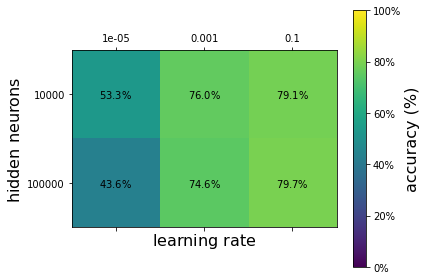

In [ ]:
import argparse # handles arguments
import sys; sys.argv=['']; del sys # required to use parser in jupyter notebooks

# Training settings
parser = argparse.ArgumentParser(description='PyTorch SUSY Example')
parser.add_argument('--dataset_size', type=int, default=100000, metavar='DS',
                help='size of data set (default: 100000)')
parser.add_argument('--high_level_feats', type=bool, default=None, metavar='HLF',
                help='toggles high level features (default: None)')
parser.add_argument('--batch-size', type=int, default=100, metavar='N',
                help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.05, metavar='LR',
                help='learning rate (default: 0.02)')
parser.add_argument('--momentum', type=float, default=0.8, metavar='M',
                help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=True,
                help='disables CUDA training')
parser.add_argument('--seed', type=int, default=2, metavar='S',
                help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                help='how many batches to wait before logging training status')
args = parser.parse_args()




# set seed of random number generator
torch.manual_seed(args.seed)


grid_search(args)


In [ ]:
"""
import pandas as pd
df_test2=pd.read_csv('gdrive/My Drive/ML4HEP_Course/data/datashrunk_SUSY_2.csv', header=0)

#df_test.reset_index(level=1)

df_test2.reset_index(drop=True, inplace=True) 

df_test2.head 
"""

"\nimport pandas as pd\ndf_test2=pd.read_csv('gdrive/My Drive/ML4HEP_Course/data/datashrunk_SUSY_2.csv', header=0)\n\n#df_test.reset_index(level=1)\n\ndf_test2.reset_index(drop=True, inplace=True) \n\ndf_test2.head \n"

### Plot learning curve 

### BO 